In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib as mpl
from matplotlib import pyplot as pl
from scipy import stats as sci_stats
from statsmodels.stats.multitest import fdrcorrection as benjamini_hochberg
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

colors = ['#FFB000', '#648FFF']

%matplotlib notebook
pl.ioff()

# Reading data:

In [39]:
## READING DATA
def change_well_format(w):
    if '_' in w:
        plate = int(w[1:3])
        t = 'LK' + str(plate) + '-'
        n = int(w.split('_')[1])
        lets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        l = lets[int(np.floor((n-1)/12))]
        return t + l + str(((n-1) % 12) + 1).zfill(2)
    else:
        return w

def get_geno_matrix(seg_names):
    d = pd.read_csv('../accessory_files/BYxRM_GenoData.csv')
    map_genos = {'B': 0, 'R': 1}
    for w in d.keys():
        if change_well_format(w) in seg_names:
            d[change_well_format(w)] = d[w].map(map_genos)
    assert len([s for s in seg_names if s in d.columns]) == len(seg_names)
    return d[['marker'] + seg_names]

def get_sig_r2(row, model):
    if row[model + '_model_p'] < 0.05:
        return row[model + '_model_r2']
    else:
        return np.nan

x_info = pd.read_csv('../accessory_files/Clones_For_Tn96_Experiment.csv')
seg_to_fit = {i[0]: i[1] for i in x_info.as_matrix(['segregant', 'initial fitness, YPD 30C'])}
tp_all = pd.read_csv('../../Analysis/TP_data_by_edge.csv')
tp = tp_all.loc[tp_all['Type']=='Experiment']
bt = pd.read_csv('../../Analysis/BT_data_by_edge.csv')
tp_dfe = pd.read_csv('../../Analysis/TP_DFE_statistics.csv')
bt_dfe = pd.read_csv('../../Analysis/BT_DFE_statistics.csv')
bt['Long.Edge'] = bt['Edge']
bt['Edge'] = bt['Long.Edge'].str[:15]
dats = {'BT': bt, 'TP': tp, 'BT.DFE': bt_dfe, 'TP.DFE': tp_dfe}
exps = {'BT': 'E1', 'TP': 'E2'}
segs_all = {exp: [i.split('.')[0] for i in dats[exp] if '.mean.s' in i] for exp in exps}
# must have at least 50 mutations with s measured
segs_use = {exp: [s for s in segs_all[exp] if len(dats[exp].loc[pd.notnull(dats[exp][s + '.mean.s'])])>=50] for exp in exps}
sorted_segs = {exp: sorted(segs_use[exp], key=lambda x: seg_to_fit[x]) for exp in exps}
gm = get_geno_matrix(segs_all['TP'])
#adding columns where the r2 is zero if the model is not significantly better than the null model
for model in ['full', 'x', 'qtl']:
    tp[model + '_sig_only_r2'] = tp.apply(lambda row: get_sig_r2(row, model), axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Reportable numbers for the paper:

In [40]:
tp_seg_edges_measured = [len(tp.loc[pd.notnull(tp[s+'.mean.s'])]) for s in segs_all['TP']]
bt_seg_edges_measured = [len(bt.loc[pd.notnull(bt[s+'.mean.s'])]) for s in segs_all['BT']]

In [41]:
print('BT. Tried 20 segregants.')
print(len(segs_all['BT']), ' segregants included.', np.mean(bt_seg_edges_measured), 'mutations measured on average,', 'min:', np.min(bt_seg_edges_measured), 'max:', np.max(bt_seg_edges_measured))
print(len(bt), 'mutations.', len(bt.loc[bt['num.measured']>0]), 'measured in at least one seg.', 'of those, they are measured in', np.mean(bt.loc[bt['num.measured']>0]['num.measured']), 'on average.')
print('Measured in', np.nanmean(bt.loc[bt['num.measured']>0]['num.measured']), 'segs on average')
print(len(bt.loc[bt['num.sig']>0]), 'significant in at least one seg,', len(bt.loc[bt['num.measured']>0].loc[bt['num.sig']==0]), 'in none,', 
      len(bt.loc[bt['num.measured']>0].loc[bt['num.sig']==0])/len(bt.loc[bt['num.measured']>0]), 'percent')

BT. Tried 20 segregants.
18  segregants included. 413.8888888888889 mutations measured on average, min: 180 max: 614
996 mutations. 710 measured in at least one seg. of those, they are measured in 10.492957746478874 on average.
Measured in 10.492957746478874 segs on average
253 significant in at least one seg, 457 in none, 0.643661971830986 percent


In [42]:
print('TP. Tried 176 segregants.')
print(len(segs_all['TP']), ' segregants included.', np.mean(tp_seg_edges_measured), 'mutations measured on average,', 'min:', np.min(tp_seg_edges_measured), 'max:', np.max(tp_seg_edges_measured))
print(len(tp), 'mutations.', 'Measured in', np.nanmean(tp['num.measured']), 'segs on average')
print(np.min(tp['num.measured']),'is the minimum # segs w measurements for one mutation, and the min # sig effects is:', np.min(tp['num.sig']))

TP. Tried 176 segregants.
162  segregants included. 65.70987654320987 mutations measured on average, min: 1 max: 82
91 mutations. Measured in 116.97802197802197 segs on average
9 is the minimum # segs w measurements for one mutation, and the min # sig effects is: 0


In [43]:
tpg = tp.loc[tp['num.measured']>=50]
print('TP. Mutations measured in at least 50 segs:', len(tpg), 'X model sig:', len(tpg.loc[tpg['x_model_p']<0.05]), 'QTL model sig:', len(tpg.loc[tpg['qtl_model_p']<0.05]))
print('None sig:', len(tpg.loc[tpg['x_model_p']>=0.05].loc[pd.isnull(tpg['qtl_model_p']) | (tpg['qtl_model_p']>=0.05)].loc[tpg['full_model_p']>=0.05]))
print('Full model sig:', len(tpg.loc[tpg['full_model_p']<0.05]), 'Full > QTL:', len(tpg.loc[tpg['model_comp_p_full_vs_qtl']<0.05]))
print('Full > X:', len(tpg.loc[tpg['model_comp_p_full_vs_x']<0.05]))
print('Detected qtls in', len(tp.loc[pd.notnull(tp['qtls'])]))

TP. Mutations measured in at least 50 segs: 80 X model sig: 64 QTL model sig: 60
None sig: 9
Full model sig: 71 Full > QTL: 50
Full > X: 61
Detected qtls in 62


In [44]:
print('X sig:', len(tpg.loc[tpg['x_model_p']<0.05]), len(tpg.loc[tpg['x_model_p']<0.05])/len(tpg))
print('QTL sig:', len(tpg.loc[tpg['qtl_model_p']<0.05]), len(tpg.loc[tpg['qtl_model_p']<0.05])/len(tpg))
print('No sig model:', len(tpg.loc[tpg['x_model_p']>=0.05].loc[pd.isnull(tpg['qtl_model_p']) | (tpg['qtl_model_p']>=0.05)]), 
      len(tpg.loc[tpg['x_model_p']<0.05].loc[pd.isnull(tpg['qtl_model_p']) | (tpg['qtl_model_p']>=0.05)])/len(tpg))
print('QTL sig only:', len(tpg.loc[tpg['qtl_model_p']<0.05].loc[tpg['x_model_p']>=0.05]), len(tpg.loc[tpg['qtl_model_p']<0.05].loc[tpg['x_model_p']>=0.05])/len(tpg))
print('X sig only:', len(tpg.loc[pd.isnull(tpg['qtl_model_p']) | (tpg['qtl_model_p']>=0.05)].loc[tpg['x_model_p']<0.05]), 
                                 len(tpg.loc[pd.isnull(tpg['qtl_model_p']) | (tpg['qtl_model_p']>=0.05)].loc[tpg['x_model_p']<0.05])/len(tpg))
print('Both sig:', len(tpg.loc[tpg['qtl_model_p']<0.05].loc[tpg['x_model_p']<0.05]), len(tpg.loc[tpg['qtl_model_p']<0.05].loc[tpg['x_model_p']<0.05])/len(tpg))
print('mean X r2 when sig:', np.mean(tpg.loc[tpg['x_model_p']<0.05]['x_model_r2']))
print('mean QTL r2 when sig:', np.mean(tpg.loc[tpg['qtl_model_p']<0.05]['qtl_model_r2']))

X sig: 64 0.8
QTL sig: 60 0.75
No sig model: 9 0.1375
QTL sig only: 7 0.0875
X sig only: 11 0.1375
Both sig: 53 0.6625
mean X r2 when sig: 0.27827836500866154
mean QTL r2 when sig: 0.48314088834069135


In [45]:
full_sig = tpg.loc[tpg['full_model_p']<0.05]
print('Full sig:', len(full_sig))
print('Full > QTL only:', len(full_sig.loc[tpg['model_comp_p_full_vs_qtl']<0.05]), len(full_sig.loc[tpg['model_comp_p_full_vs_qtl']<0.05])/len(tpg))
print('Full > X only:', len(full_sig.loc[tpg['model_comp_p_full_vs_x']<0.05]), len(full_sig.loc[tpg['model_comp_p_full_vs_x']<0.05])/len(tpg))
print('Full > Both:', len(full_sig.loc[tpg['model_comp_p_full_vs_qtl']<0.05].loc[tpg['model_comp_p_full_vs_x']<0.05]), 
      len(full_sig.loc[tpg['model_comp_p_full_vs_x']<0.05].loc[tpg['model_comp_p_full_vs_qtl']<0.05])/len(tpg))

Full sig: 71
Full > QTL only: 50 0.625
Full > X only: 61 0.7625
Full > Both: 40 0.5


## General plotting functions:

In [46]:
def get_data_subset(xvals, yvals, xerrs, yerrs, geno_row1, geno_row1_equals, geno_row2=None, geno_row2_equals=None):
    if geno_row2:
        xs = [xvals[s] for s in range(len(xvals)) if geno_row1[s]==geno_row1_equals and geno_row2[s]==geno_row2_equals]
        ys = [yvals[s] for s in range(len(yvals)) if geno_row1[s]==geno_row1_equals and geno_row2[s]==geno_row2_equals]
        if yerrs:
            ye = [yerrs[s] for s in range(len(yerrs)) if geno_row1[s]==geno_row1_equals and geno_row2[s]==geno_row2_equals]
        else:
            ye = None
        if xerrs:
            xe = [xerrs[s] for s in range(len(xerrs)) if geno_row1[s]==geno_row1_equals and geno_row2[s]==geno_row2_equals]
        else:
            xe=None        
    else:
        xs = [xvals[s] for s in range(len(xvals)) if geno_row1[s]==geno_row1_equals]
        ys = [yvals[s] for s in range(len(yvals)) if geno_row1[s]==geno_row1_equals]
        if yerrs:
            ye = [yerrs[s] for s in range(len(yerrs)) if geno_row1[s]==geno_row1_equals]
        else:
            ye = None
        if xerrs:
            xe = [xerrs[s] for s in range(len(xerrs)) if geno_row1[s]==geno_row1_equals]
        else:
            xe = None
    return xs, ys, xe, ye

def plot_w_qtl_color(sub, df_row, show_title, measured, xvals, yvals, plot_w_color, qtl_to_show=None, xerrs=None, yerrs=None, point_size = 2, error_size = 0.5):
    geno_dat = gm.as_matrix(['marker'] + measured)
    if show_title:
        sub.set_title(str(df_row['Gene.Use']), fontsize=7, y=0.95)
    if str(df_row['full.model.qtls']) != 'nan' and plot_w_color:
        if qtl_to_show: #ignore all qtls except the 
            edge_qtls = [i.split(';')[0] for i in str(df_row['full.model.qtls']).split('|') if i.split(';')[0] == qtl_to_show]
        else:
            edge_qtls_unsorted = [i.split(';')[0] for i in str(df_row['full.model.qtls']).split('|')]
            qtl_effects = [float(i) for i in str(df_row['full_model_coeffs']).split(';')[2:]]
            edge_qtls = [i for jnk,i in sorted(zip(qtl_effects, edge_qtls_unsorted), reverse=True)]
    else:
        edge_qtls = []
    geno_rows = [list([row[1:] for row in geno_dat if '_'.join(row[0].split('_')[1:3]) == eq][0]) for eq in edge_qtls]
    if len(geno_rows) == 1:
        geno_row = geno_rows[0]
        for i in range(2):
            xs, ys, xe, ye = get_data_subset(xvals, yvals, xerrs, yerrs, geno_rows[0], i)
            sub.errorbar(x=xs, y=ys, xerr=xe, yerr=ye, marker='o', c=colors[i], linestyle='', markersize=point_size, elinewidth=error_size,
                         markeredgewidth=0.5)
    elif len(geno_rows) > 1:
        for i in range(2):
            xs1, ys1, xe1, ye1 = get_data_subset(xvals, yvals, xerrs, yerrs, geno_rows[0], i, geno_row2=geno_rows[1], geno_row2_equals=0)
            xs2, ys2, xe2, ye2 = get_data_subset(xvals, yvals, xerrs, yerrs, geno_rows[0], i, geno_row2=geno_rows[1], geno_row2_equals=1)
            sub.errorbar(x=xs1, y=ys1, xerr=xe1, yerr=ye1, marker='o', c=colors[i], linestyle='', markersize=point_size, elinewidth=error_size, 
                         markeredgewidth=0.5)
            sub.errorbar(x=xs2, y=ys2, xerr=xe2, yerr=ye2, marker='o', linestyle='', c=colors[i], alpha=0.7, markersize=point_size, elinewidth=error_size, 
                         markeredgewidth=0.5, markerfacecolor='none')
    else:
        sub.errorbar(x=xvals, y=yvals, xerr=xerrs, yerr=yerrs, marker='o', c='k', linestyle='', markersize=point_size, elinewidth=error_size,  markeredgewidth=0.5)   
        

## Making DFE-related plots:

In [47]:
def get_dfe(df, segname):
    use_df = df.loc[pd.notnull(df[segname + '.mean.s'])]
    return list(use_df[segname + '.mean.s'])

def plot_dfe_stat(sub, df_row, segs, x_list, gm=None, qtl_color=False, show_pvals=False, square_root=False, point_s=2):
    point_size = 2
    y_list = list(df_row[segs])
    if square_root: y_list = np.sqrt(np.array(y_list))
    pval = df_row['x_model_p']
    print(pval)
    if show_pvals:
        if pval < 0.001:
            sub.annotate('p=' + "{:.2E}".format(pval), xy=(0.9, 0.85), xycoords='axes fraction', fontsize=6, horizontalalignment='right', verticalalignment='bottom')
        else:
            sub.annotate('p=' + str(pval)[:4], xy=(0.9, 0.85), xycoords='axes fraction', fontsize=6, horizontalalignment='right', verticalalignment='bottom')
    plot_w_qtl_color(sub, df_row, None, segs, x_list, y_list, qtl_color, point_size=point_s)
    sub.set_xlim([-0.16, 0.12])
    y_range = max(y_list)-min(y_list)
    sub.set_ylim([min(y_list)-y_range*0.25, max(y_list)+y_range*0.25]) # I don't know why pyplot is not doing this well automatically here

In [48]:
## Making DFE heatmap arrays
data_by_fit_ranks = {'BT': [[], [], []], 'TP': [[], [], []]} #xdata, ydata, weights (scaled to make columns sum to one)
data_by_seg = {'BT': dict(), 'TP': dict()}
sorted_segs = {exp: sorted(segs_use[exp], key=lambda x: seg_to_fit[x]) for exp in exps}
fit_ranks = {exp: {s: sorted_segs[exp].index(s) for s in segs_use[exp]} for exp in exps}
exp_binnin = {'BT': 1, 'TP': 1}
for exp in exps:
    for seg in segs_use[exp]:
        td = dats[exp].loc[dats[exp][seg + '.total.cbcs']>=4]
        data_by_fit_ranks[exp][0] += [fit_ranks[exp][seg]] * len(td)
        data_by_fit_ranks[exp][1] += list(td[seg + '.mean.s'])
        # these are the weights, which are all 1/((number of segs per bin)*(num edges with measurements for this seg)). This allows us to plot so columns sum to one (are normed).
        data_by_fit_ranks[exp][2] += list(np.array([1/exp_binnin[exp] for i in range(len(td))])/len(td)) 
        data_by_seg[exp][seg] = list(td[seg + '.mean.s'])

# FIGURE 2

0.0343397895799612
4.125398447394122e-31
7.386069094834634e-14
4.088895290612011e-12


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


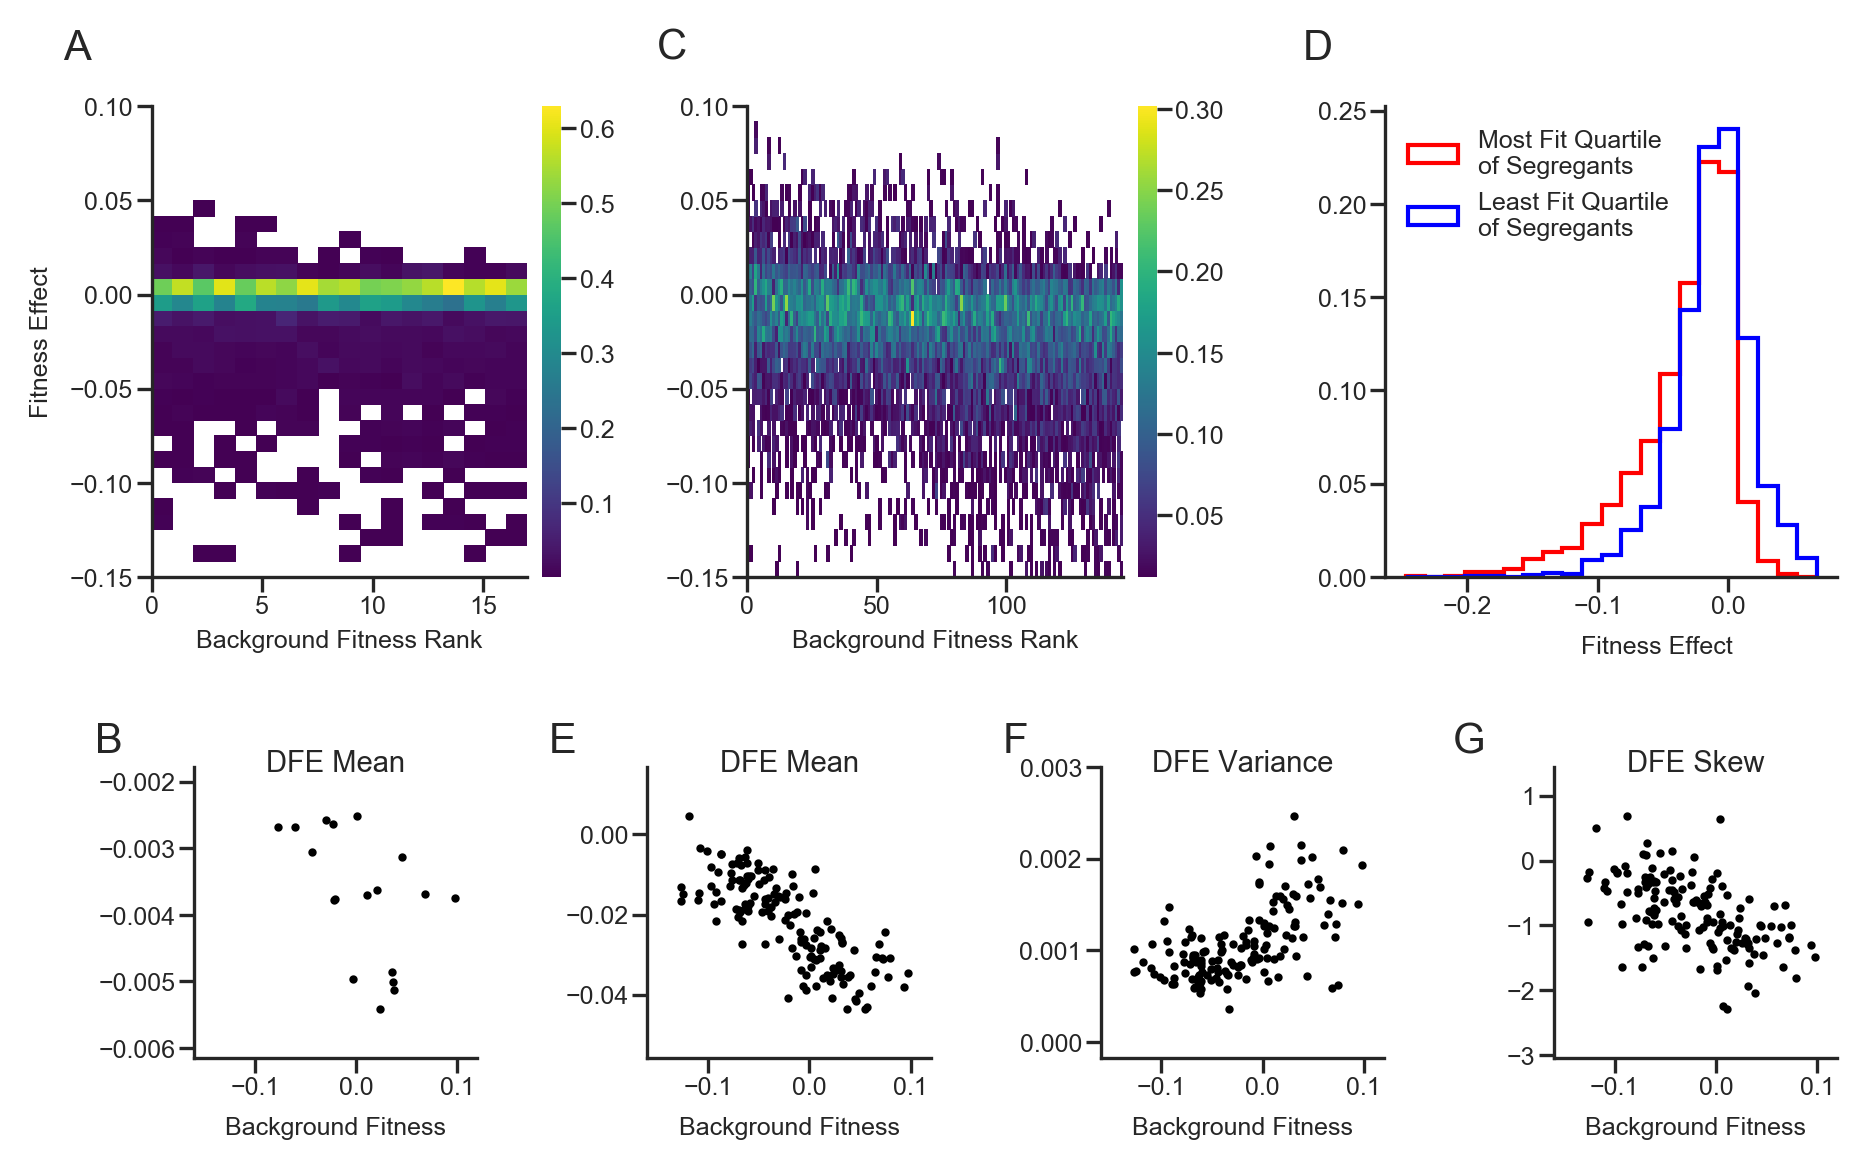

In [49]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

def quartile_histo(sub, exp):
    num_to_combine = int(len(segs_use[exp])/4)
    top_dfe, bottom_dfe = [], [],   
    for i in range(num_to_combine):
        bottom_dfe += get_dfe(dats[exp], sorted_segs[exp][i])
        top_dfe += get_dfe(dats[exp], sorted_segs[exp][len(sorted_segs[exp])-1-i])
    bin_lefts = [(-16.15+i)*0.015-0.005 for i in range(22)]
    sub.hist(top_dfe, bins=bin_lefts, label='Most Fit Quartile\nof Segregants', histtype="step", color="r", weights=np.ones_like(top_dfe)/float(len(top_dfe)))
    sub.hist(bottom_dfe, bins=bin_lefts, label='Least Fit Quartile\nof Segregants', histtype="step", color="b", weights=np.ones_like(bottom_dfe)/float(len(bottom_dfe)))

def make_dfe_plot(exps_list, outname):
    all_pads = 1
    dfe_range = [-0.15, 0.07]
    f = pl.figure(figsize=(7.25, 4.2), dpi=300)
    pl.subplots_adjust(wspace=0.6)
    gs0 = gridspec.GridSpec(16, 40)
    fit_heatmaps_gs = [gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:8,:10]),
                       gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:8,14:24])]
    stats_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[11:,1:])
    stats_subs = [pl.Subplot(f, stats_gs[i]) for i in range(4)]
    hist_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:8,29:])
    hist_sub = pl.Subplot(f, hist_gs[0])
     
    lets = [['A', 'B', 'C'], ['D', 'E', 'F']]
    for c in range(2):
        exp = exps_list[c]
        hm_x, hm_y, w = data_by_fit_ranks[exp]
        hm_sub = pl.Subplot(f, fit_heatmaps_gs[c][0])        
        combine_bin = len(segs_use[exp])/exp_binnin[exp]
        h = hm_sub.hist2d(hm_x, hm_y, weights=w, bins=[combine_bin, [-0.15+i*0.25/30 for i in range(30)]], cmin=1e-20, 
                          cmap=pl.cm.viridis)
        cb = colorbar(h[3])
        cb.ax.tick_params(labelsize=6, pad=all_pads)
        cb.outline.set_visible(False)
        hm_sub.tick_params(axis='both', which='major', labelsize=6, pad=all_pads)
        hm_sub.set_ylim(dfe_range)
        hm_sub.annotate('Background Fitness Rank', fontsize=6, xy=(0.5, -0.15), xycoords="axes fraction", horizontalalignment="center")
        if c == 0: 
            hm_sub.set_ylabel('Fitness Effect', fontsize=6)
            hm_sub.annotate('A', fontsize=10, xy=(-0.2, 1.1), xycoords="axes fraction", horizontalalignment="center")
        else:
            hm_sub.annotate('C', fontsize=10, xy=(-0.2, 1.1), xycoords="axes fraction", horizontalalignment="center")
        hm_sub.set_ylim([-0.15, 0.1])
        f.add_subplot(hm_sub)
        sns.despine(ax=hm_sub)

    stats = [['BT', 'mean', 'DFE Mean', 'B'], ['TP', 'mean', 'DFE Mean', 'E'], ['TP', 'variance', 'DFE Variance', 'F'], 
             ['TP', 'skew', 'DFE Skew', 'G']]
    for s in range(len(stats)):
        plot_dfe_stat(stats_subs[s], dats[stats[s][0]+'.DFE'].loc[dats[stats[s][0]+'.DFE']['DFE.statistic']==stats[s][1]].iloc[0], 
             segs_use[stats[s][0]], [seg_to_fit[seg] for seg in segs_use[stats[s][0]]], show_pvals=False, qtl_color=False, point_s=1.5)
        stats_subs[s].annotate(stats[s][3], fontsize=10, xy=(-0.3, 1.05), xycoords="axes fraction", horizontalalignment="center")
        stats_subs[s].set_title(stats[s][2], fontsize=7, y=0.9)
        stats_subs[s].set_xlabel('Background Fitness', fontsize=6)
    
    quartile_histo(hist_sub, 'TP')
    hist_sub.set_xlabel('Fitness Effect', fontsize=6, x=0.6)
    hist_sub.legend(fontsize=6, frameon=False, loc='upper left')
    hist_sub.annotate('D', fontsize=10, xy=(-0.15, 1.1), xycoords="axes fraction", horizontalalignment="center")
    f.add_subplot(hist_sub)
    hist_sub.tick_params(axis='both', which='major', labelsize=6, pad=all_pads)
    sns.despine(ax=hist_sub)
    jnk = [stats_subs[x].tick_params(axis='both', which='major', labelsize=6, pad=all_pads) for x in range(4)]
    jnk = [sns.despine(ax=stats_subs[x]) for x in range(4)]
    jnk = [f.add_subplot(stats_subs[x]) for x in range(4)]
    f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
             
    
make_dfe_plot(['BT', 'TP'], '../../Figures/Figure2.pdf')

## Quartile histogram plot for BT, for supplement

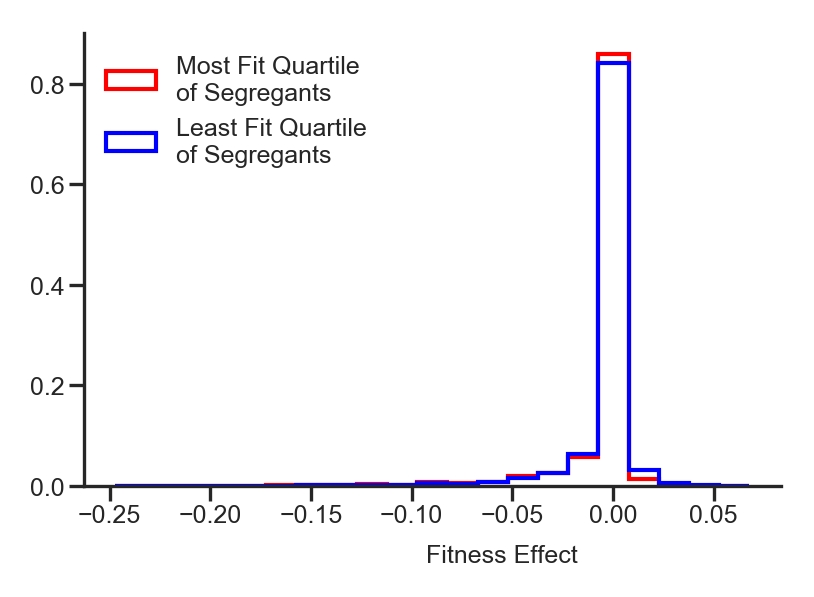

In [50]:
def bt_dfe_plot(outname):
    all_pads = 1
    dfe_range = [-0.15, 0.07]
    f, hist_sub = pl.subplots(1, 1, figsize=(3, 2), dpi=300)
    quartile_histo(hist_sub, 'BT')
    hist_sub.set_xlabel('Fitness Effect', fontsize=6, x=0.6)
    hist_sub.legend(fontsize=6, frameon=False, loc='upper left')
    hist_sub.tick_params(axis='both', which='major', labelsize=6, pad=all_pads)
    sns.despine(ax=hist_sub)
    f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
             
bt_dfe_plot('../../Figures/supp_figs/BT_dfe_quartiles.pdf')

## Plotting DFE statistics for each experiment:

0.0343397895799612
0.2946106639374643
0.7649201675089152
0.4296727783285341
0.01912266155192321
0.7454871694188404


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


4.125398447394122e-31
7.386069094834634e-14
4.088895290612011e-12
0.09793271703575407
3.7443228269879627e-22
1.9943604376004995e-07


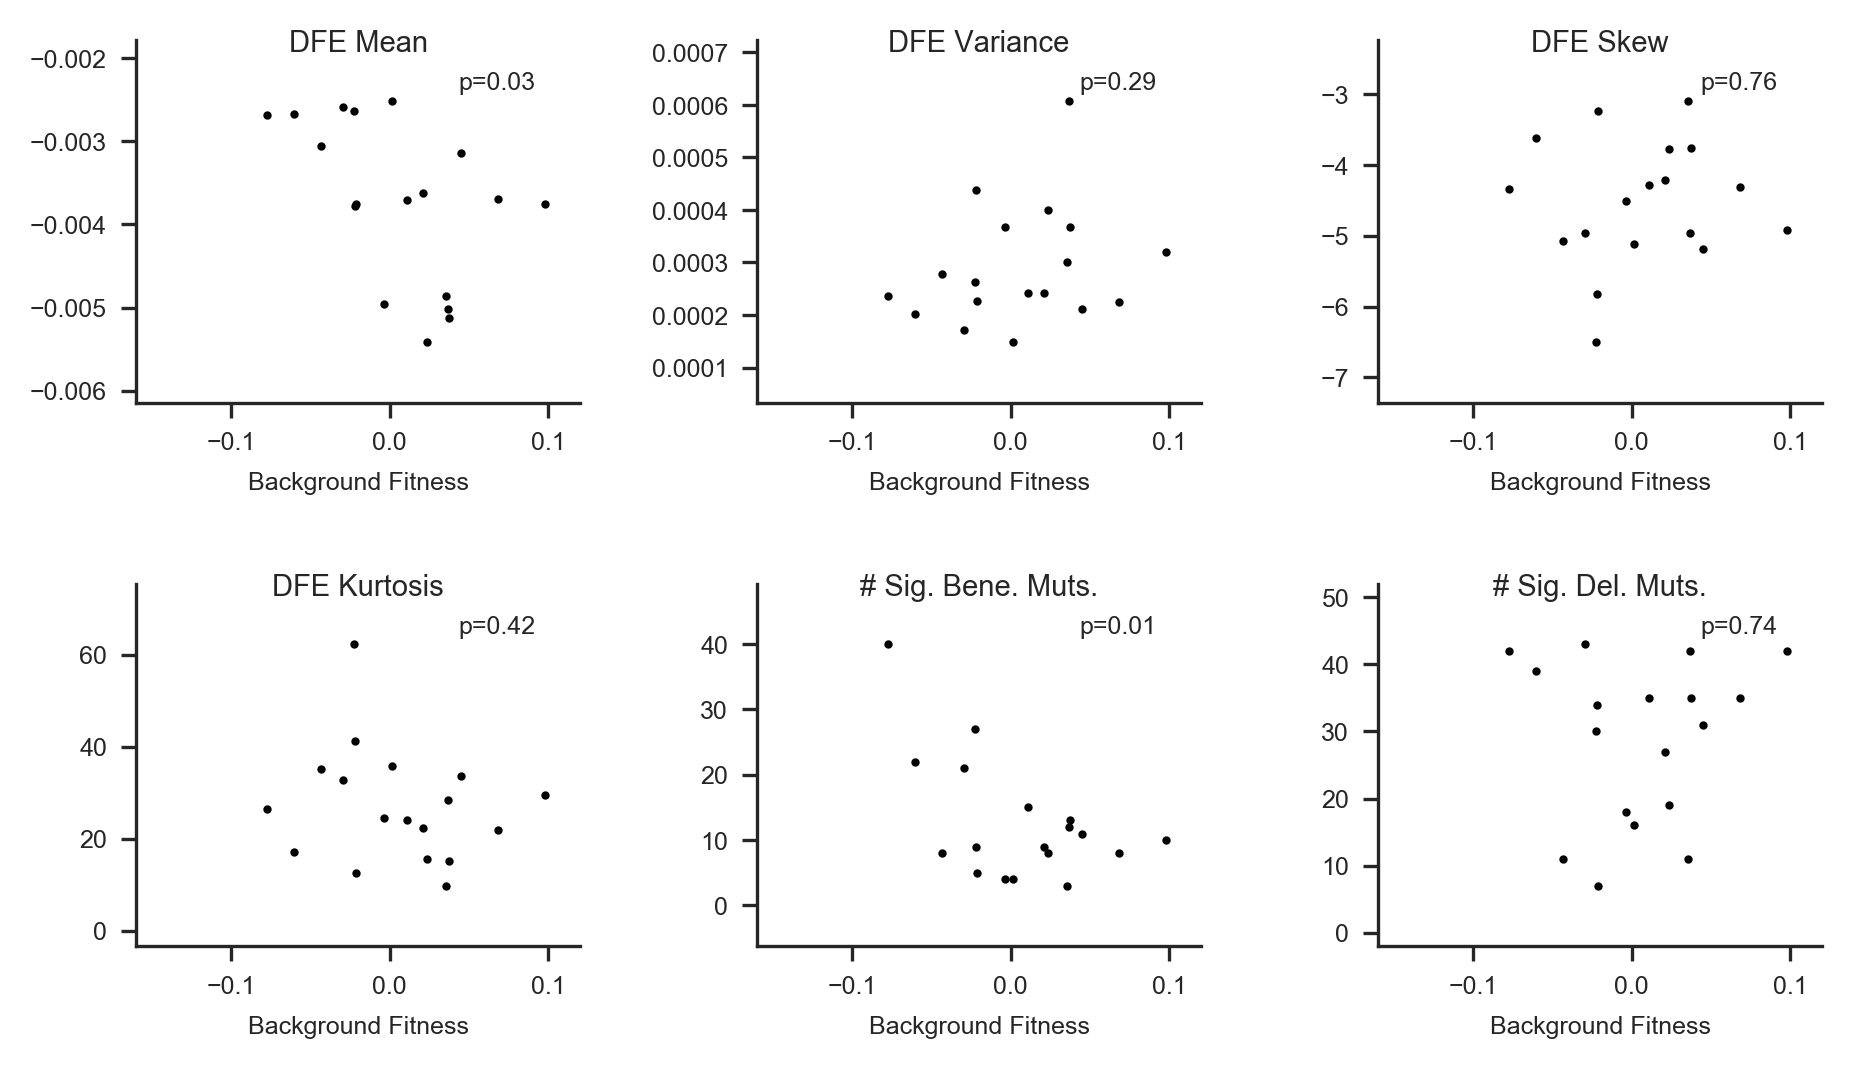

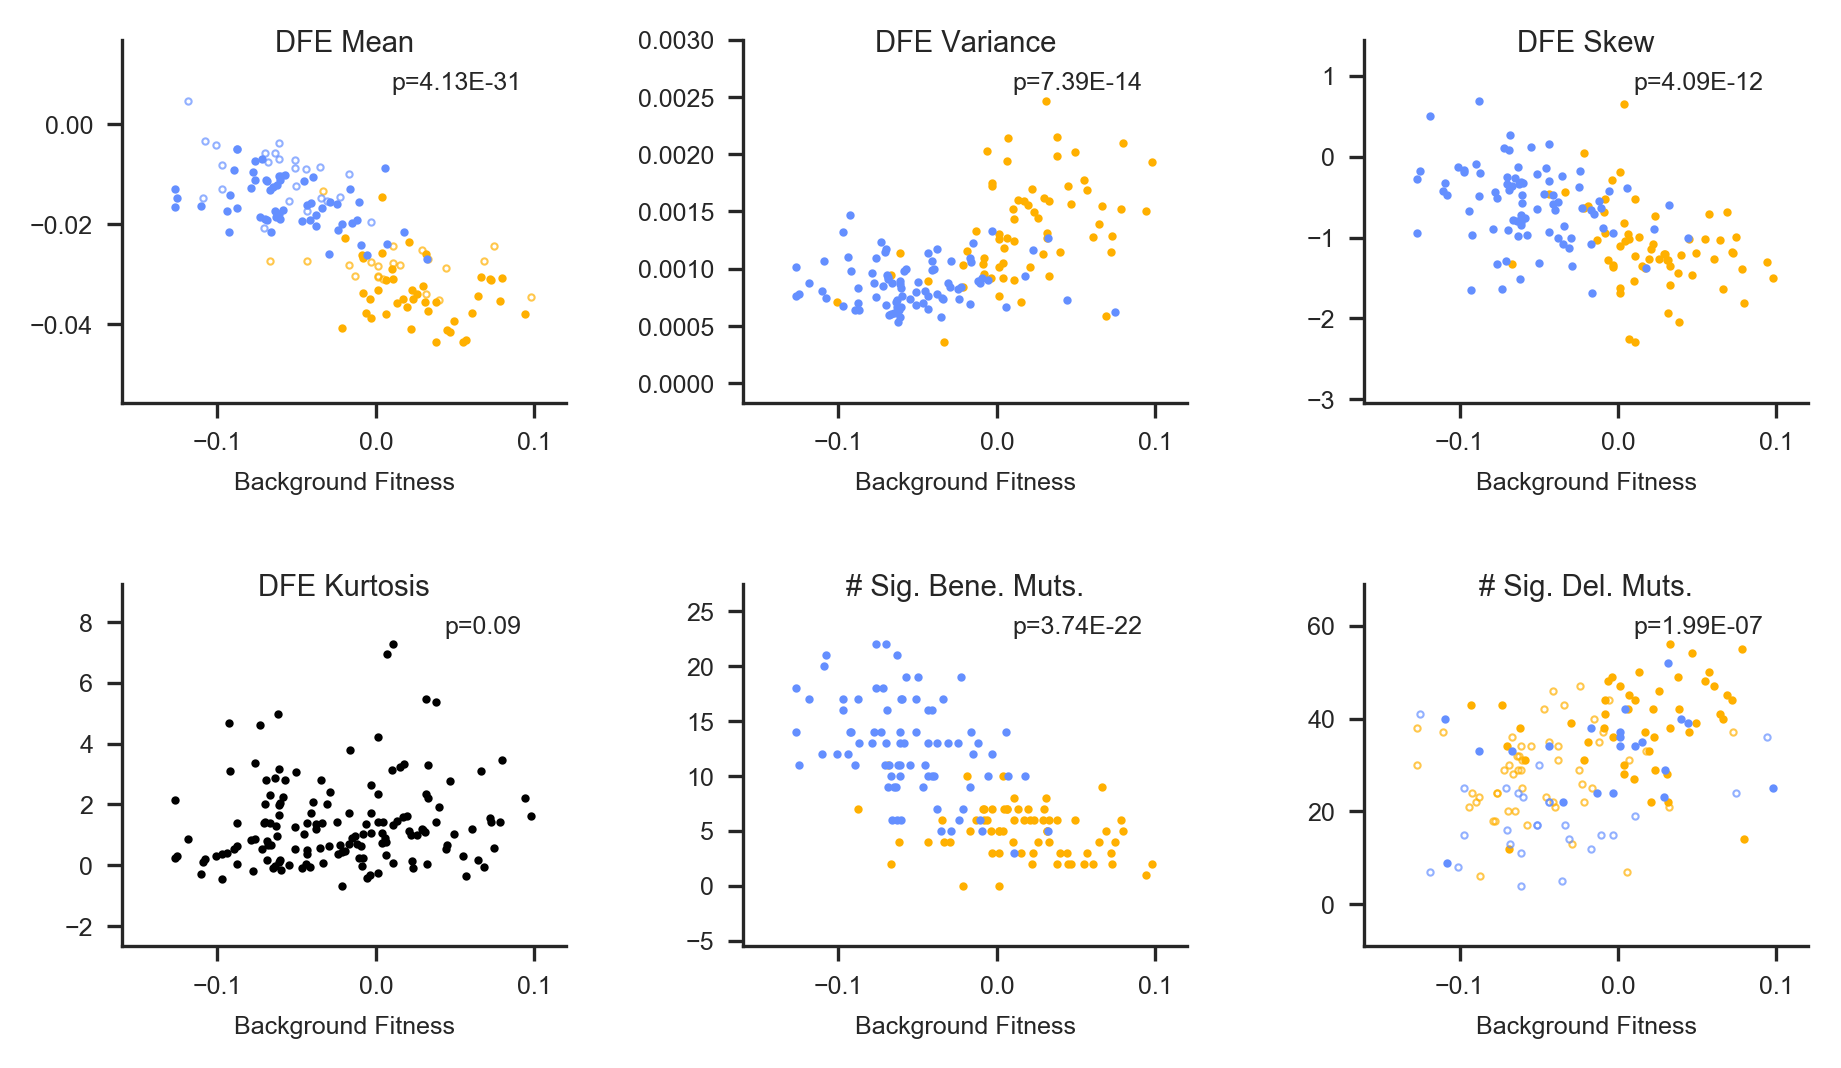

In [51]:
def plot_dfe_statistics(exp, outname):
    all_pads = 1
    dfe_range = [-0.15, 0.07]
    f, subs = pl.subplots(2, 3, figsize=(7.25, 4), dpi=300)
    pl.subplots_adjust(wspace=0.4, hspace=0.5)
    stats = ['mean', 'variance', 'skew', 'kurtosis', 'significant.beneficial.mutations', 'significant.deleterious.mutations']
    stat_names = ['DFE Mean', 'DFE Variance', 'DFE Skew', 'DFE Kurtosis', '# Sig. Bene. Muts.', '# Sig. Del. Muts.']
    s = 0
    for suba in subs:
        for sub in suba:
            plot_dfe_stat(sub, dats[exp+'.DFE'].loc[dats[exp+'.DFE']['DFE.statistic']==stats[s]].iloc[0], segs_use[exp], 
                          [seg_to_fit[seg] for seg in segs_use[exp]], show_pvals=True, qtl_color=True,point_s=1.5)
            sub.set_title(stat_names[s], fontsize=7, y=0.9)
            sub.set_xlabel('Background Fitness', fontsize=6)
            sub.tick_params(axis='both', which='major', labelsize=6)
            s += 1
    sns.despine()
    f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
             
    
plot_dfe_statistics('BT', '../../Figures/supp_figs/BT_dfe_stats.pdf')
plot_dfe_statistics('TP', '../../Figures/supp_figs/TP_dfe_stats.pdf')

## Genetic Determinant Plots

In [52]:
def make_single_determinant_plot(sub, df_row, segs, show_title=True, plot_w_color=True, one_qtl=None):
    measured = [seg for seg in segs if pd.notnull(df_row[seg + '.mean.s'])]
    sub.axhline(y=0, xmin=0, xmax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
    xs = [seg_to_fit[measured[s]] for s in range(len(measured))]
    ys = [df_row[measured[s] + '.mean.s'] for s in range(len(measured))]
    ye = [df_row[measured[s] + '.stderr.s'] for s in range(len(measured))]
    plot_w_qtl_color(sub, df_row, show_title, measured, xs, ys, plot_w_color, yerrs=ye, qtl_to_show=one_qtl)
    sub.set_xlim([-0.16, 0.12])
    sub.set_ylim([-0.2, 0.08])


# TWO ALTERNATE WAYS OF LOOKING AT X VS S (FOR SUPPLEMENTARY FIGS)
     
def make_one_to_one_determinant_plot(sub, df_row, segs, show_title=True, plot_w_color=True):
    measured = [seg for seg in segs if pd.notnull(df_row[seg + '.mean.s'])]
    sub.plot([-0.2, 0.15], [-0.2, 0.15], color='#333333', linestyle='dashed', alpha=0.5, lw=1)
    xs = [seg_to_fit[measured[s]] for s in range(len(measured))]
    ys = [seg_to_fit[measured[s]] + df_row[measured[s] + '.mean.s'] for s in range(len(measured))]
    ye = [df_row[measured[s] + '.stderr.s'] for s in range(len(measured))]
    plot_w_qtl_color(sub, df_row, show_title, measured, xs, ys, plot_w_color, yerrs=ye)
    sub.set_xlim([-0.16, 0.12])
    sub.set_ylim([-0.25, 0.09])
    sub.set_xlabel('Background Fitness', fontsize=7)
    sub.set_ylabel('Final Fitness', fontsize=7)
        
def make_reversion_determinant_plot(sub, df_row, segs, show_title=True, plot_w_color=True):
    measured = [seg for seg in segs if pd.notnull(df_row[seg + '.mean.s'])]
    sub.axhline(y=0, xmin=0, xmax=1, color='#333333', linestyle='dashed', alpha=0.5, lw=1)
    xs = [seg_to_fit[measured[s]] + df_row[measured[s] + '.mean.s'] for s in range(len(measured))]
    ys = [-1*df_row[measured[s] + '.mean.s'] for s in range(len(measured))]
    xe = [df_row[measured[s] + '.stderr.s'] for s in range(len(measured))]
    plot_w_qtl_color(sub, df_row, show_title, measured, xs, ys, plot_w_color, xerrs=xe, yerrs=xe) # shared errors
    sub.set_xlim([-0.25, 0.12])
    sub.set_ylim([-0.1, 0.2])
    sub.set_xlabel('Final Fitness', fontsize=7)
    sub.set_ylabel('Reversion Fitness Effect', fontsize=7)

## CHOOSING EXAMPLE MUTATIONS:

In [53]:
refs = [
    'TATATTGAACTTTAC' # reference
]
ex_edges = [
    'GAACTCAGGTTCCAT',  #in MME1
    'AGTGTTAATCAGACC',  #nearby PAH1
    'TTATATTTATTTGCT',  #in SIR3
    'GTTTAGCTTCCGTTG',  #in RPL16A
    'CTTTCTTGTGTATTT',  #in BRR1
    'TGGAGTCTTTGTTGA',  #in NOT3
    'TCAACAACCTATGCA',  #in EBS1
    'AGTGTATGATAATAT',  #nearby KRI1
    'CCAACACAGGCTTCG',  #in NOP16
    'TCAAAGCATGAAAAA',  #in SUM1
    'CAAGGATCCCCGTAG',  #in BUL1
]
examples = refs + ex_edges 

# FIGURE 3

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


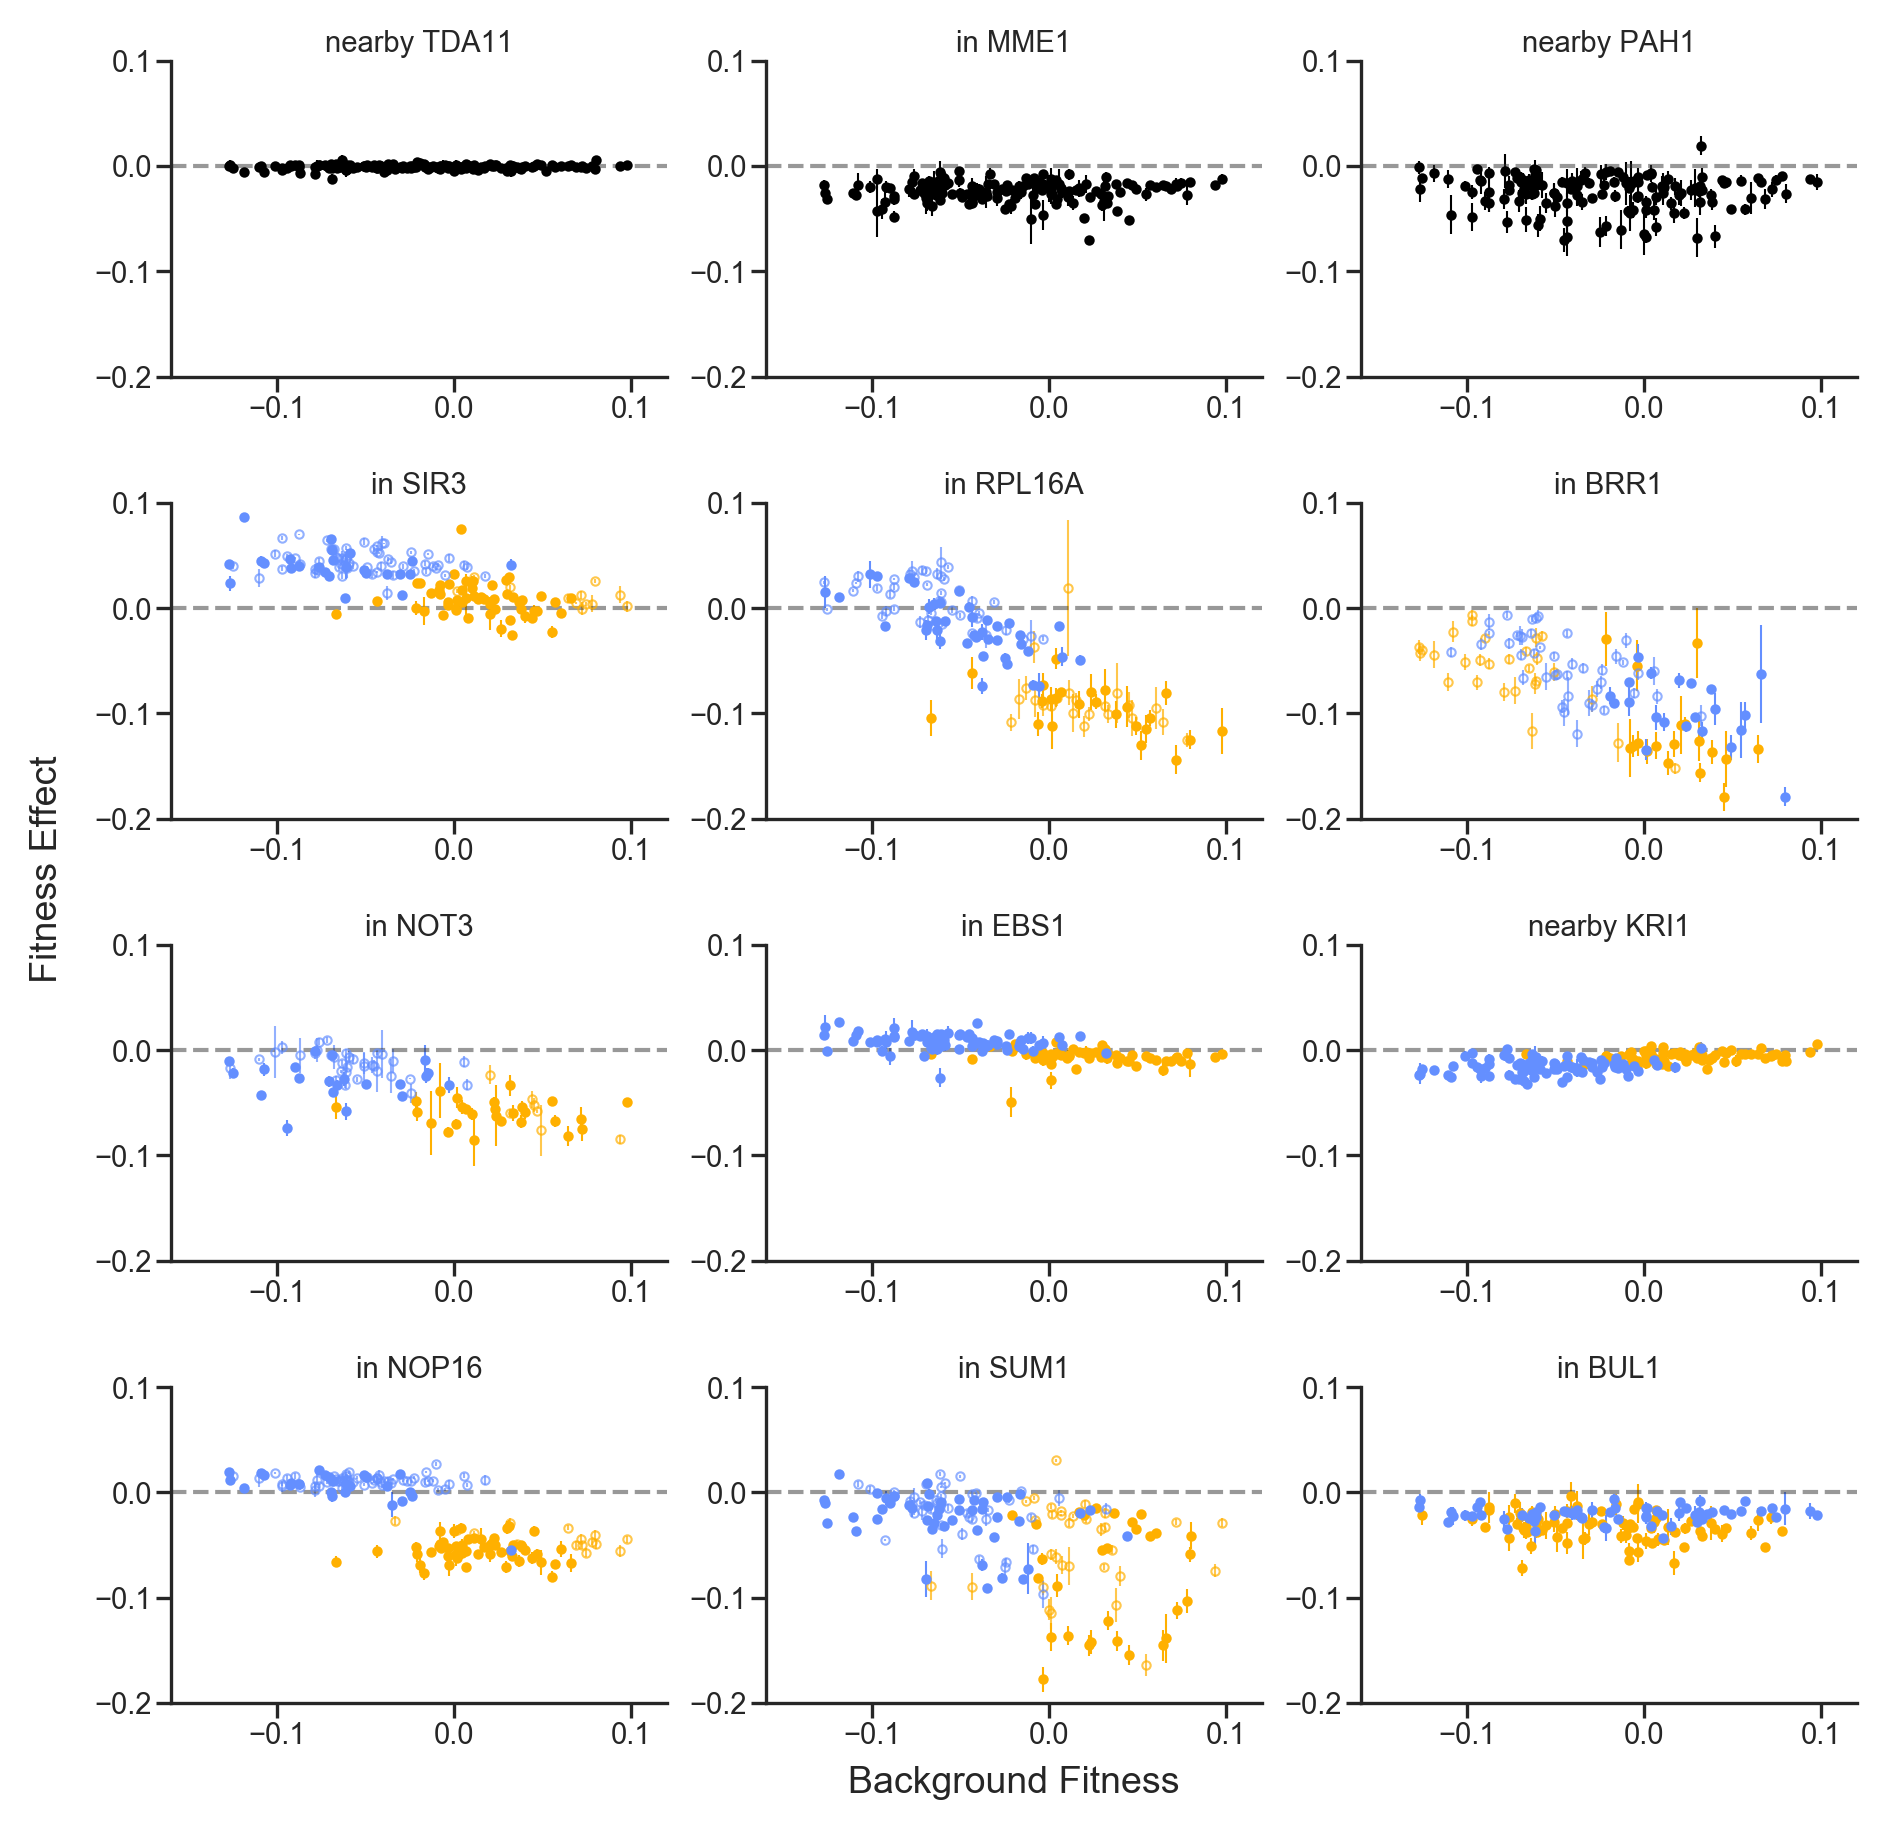

In [54]:
def make_examples_figure3(outname, gm, plot_errors=False, plot_std_dev=True):
    df = tp.loc[tp['num.measured']>=50].sort_values(by='var', ascending=True)
    f, subps = pl.subplots(4, 3, figsize=(7.25, 7.25), dpi=300)
    pl.subplots_adjust(hspace=0.4)
    c = 0
    for subarr in subps:
        r = 0
        for sub in subarr:
            edge = examples[c*3+r]
            df_row = tp_all.loc[tp_all['Edge']==edge].iloc[0]
            make_single_determinant_plot(sub, df_row, segs_all['TP'])
            sub.set_xlim([-0.16, 0.12])
            sub.set_ylim([-0.2, 0.1])
            sub.tick_params(axis='both', which='major', labelsize=7, pad=1)
            r += 1
        c += 1
    
    subps[1][0].annotate('Fitness Effect', fontsize=9, xy=(-0.25, -0.16), xycoords='axes fraction', rotation=90, ha='center', va='center')
    subps[3][1].annotate('Background Fitness', fontsize=9, xy=(0.5, -0.2), xycoords='axes fraction', ha='center', va='top')
    sns.despine()
    f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
    
make_examples_figure3('../../Figures/Figure3.pdf', gm, plot_errors=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


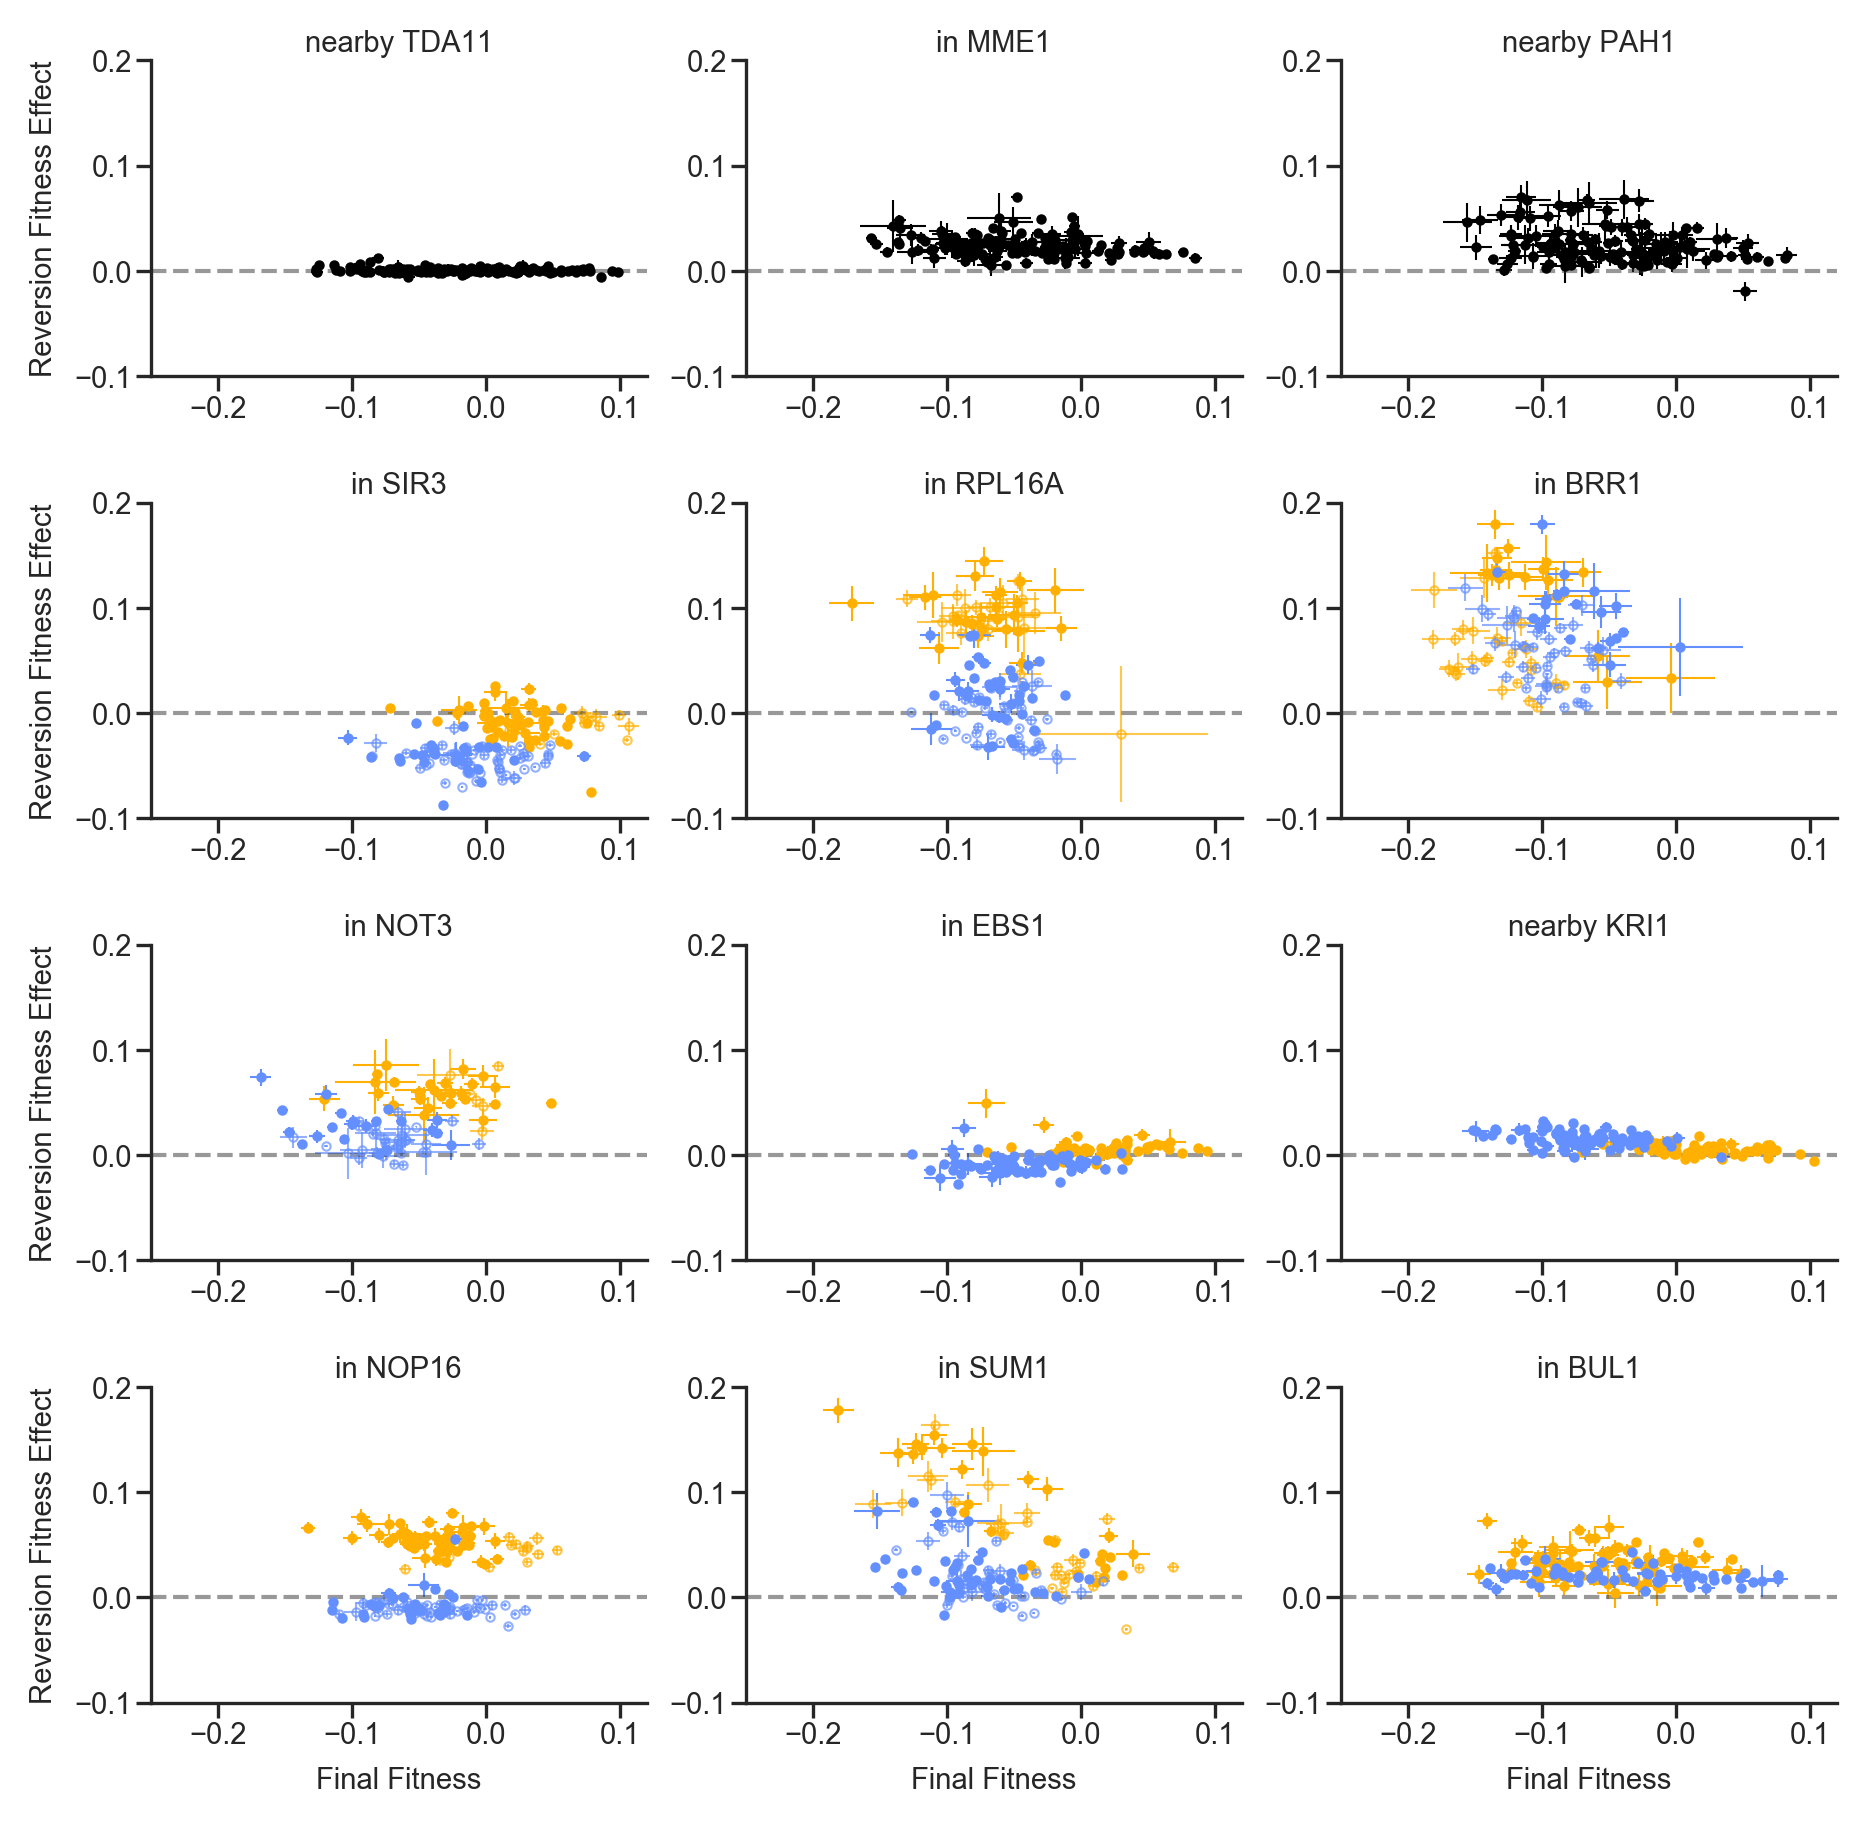

In [55]:
def make_examples_figure_reversions(outname, gm, plot_errors=False, plot_std_dev=True):
    df = tp.loc[tp['num.measured']>=50].sort_values(by='var', ascending=True)
    f, subps = pl.subplots(4, 3, figsize=(7.25, 7.25), dpi=300)
    pl.subplots_adjust(hspace=0.4)
    c = 0
    for subarr in subps:
        r = 0
        for sub in subarr:
            edge = examples[c*3+r]
            df_row = tp_all.loc[tp_all['Edge']==edge].iloc[0]
            make_reversion_determinant_plot(sub, df_row, segs_all['TP'])
            sub.tick_params(axis='both', which='major', labelsize=7, pad=1)
            if r > 0:
                sub.set_ylabel('')
            if c < len(subps)-1:
                sub.set_xlabel('')
            r += 1
        c += 1

    sns.despine()
    f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
    
make_examples_figure_reversions('../../Figures/supp_figs/reversions_like_Figure3.pdf', gm, plot_errors=True)

# FIGURE 4

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


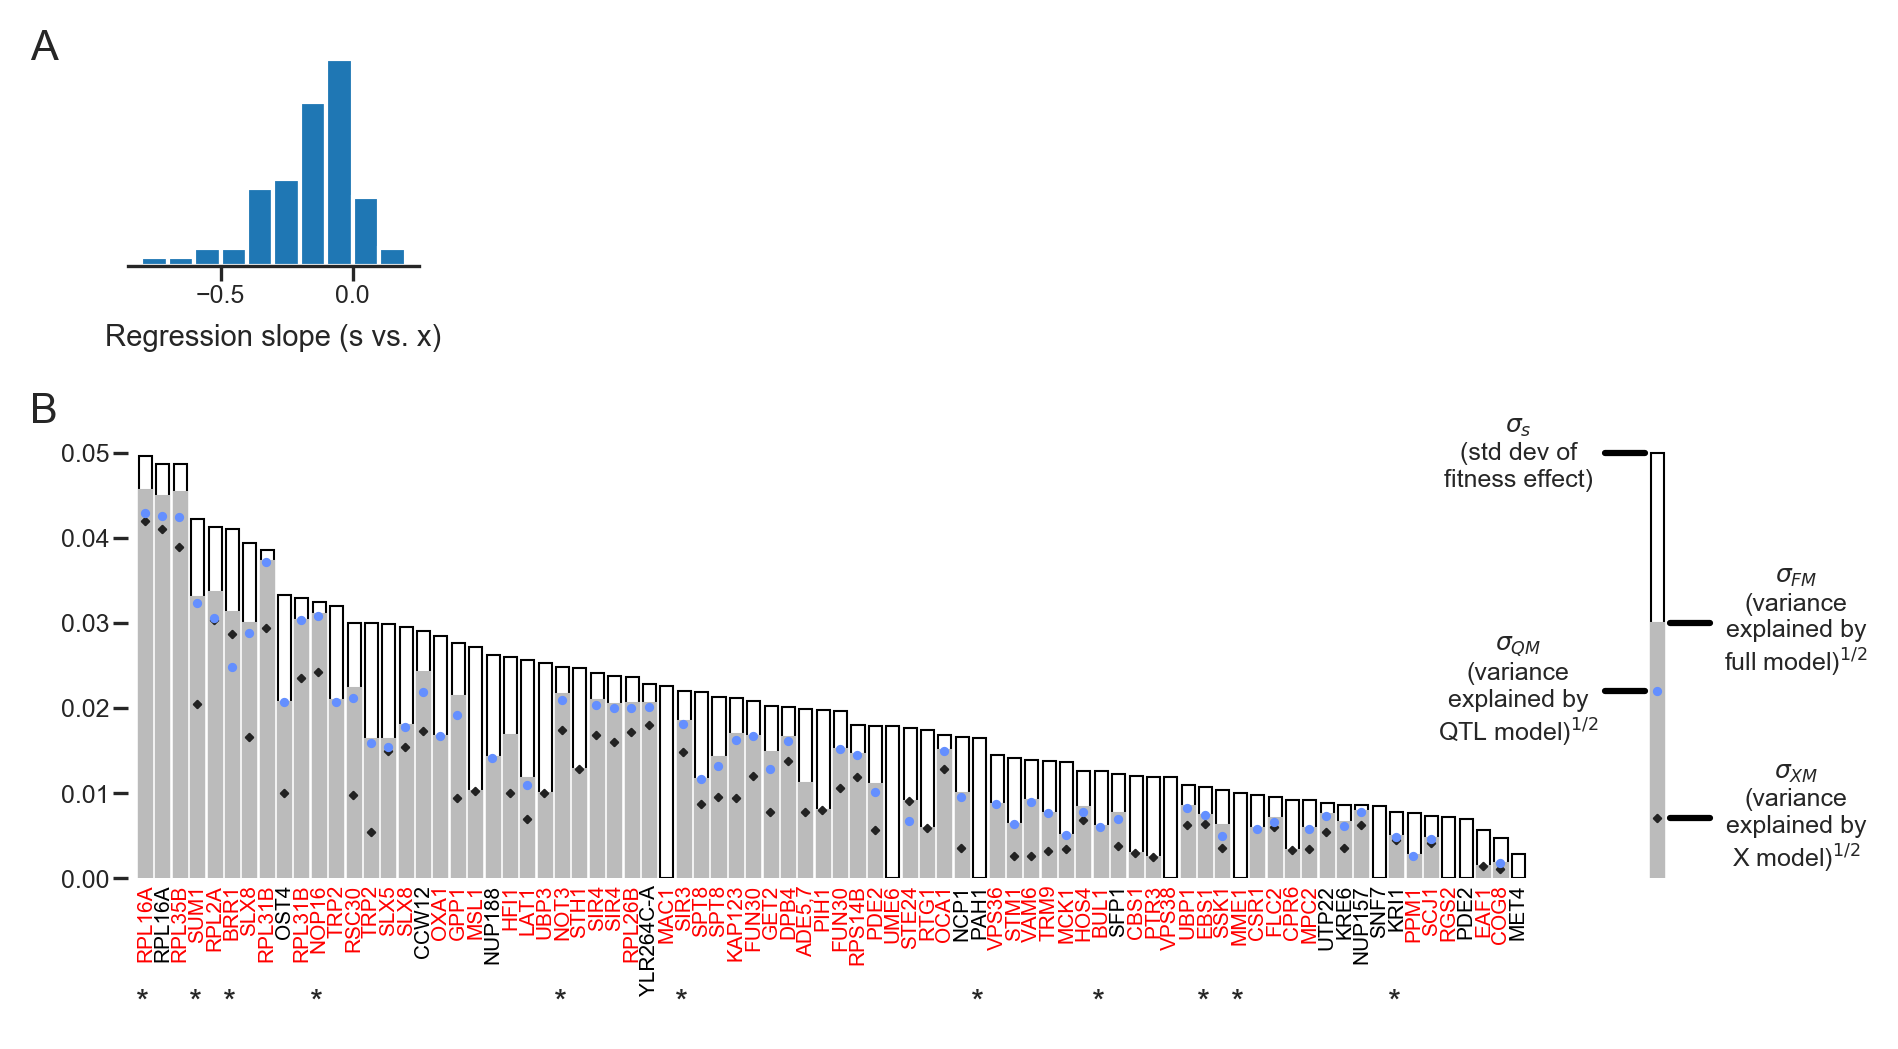

In [56]:
def make_determinants_figure(outname):
    
    df = tp.loc[tp['num.measured']>=50].sort_values(by='var', ascending=False)
    f = pl.figure(figsize=(7.25, 4), dpi=300)
    gs0 = gridspec.GridSpec(12, 5)
    top_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[5:11,:])
    top_sub = pl.Subplot(f, top_gs[0])    
    hist_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:3,:1])
    hist_sub = pl.Subplot(f, hist_gs[0])    
    f.add_subplot(top_sub)
    f.add_subplot(hist_sub)
    
    gene_descrips = list(df['Gene.Use'])
    edges_in_order = list(df['Edge'])
    example_loc = len(df)+7
    xbars = np.array([i for i in range(len(df))] + [example_loc])
    
    top_sub.tick_params(axis='y', which='major', labelsize=6, pad=1)
    top_sub.tick_params(axis='x', which='major', labelsize=5, pad=-2)
    top_sub.set_xlim([-1, len(gene_descrips)+16])
    ex_dev, ex_full, ex_qtl, ex_x = 0.05, 0.03, 0.022, 0.007
    top_sub.bar(xbars, list(np.sqrt(df['var'])) + [ex_dev], color='none', edgecolor='black', lw=0.5, width=0.75)
    top_sub.bar(xbars, list(np.sqrt(df['full_sig_only_r2']*df['var'])) + [ex_full], color='#BBBBBB', edgecolor='#BBBBBB', lw=0.5, width=0.75)
    top_sub.scatter(xbars-0.05, list(np.sqrt(df['x_sig_only_r2']*df['var'])) + [ex_x], color='#222222', marker='x', zorder=3, s=1.5)
    top_sub.scatter(xbars-0.05, list(np.sqrt(df['qtl_sig_only_r2']*df['var'])) + [ex_qtl], color=colors[1], marker='o', zorder=4, s=1.5)
    
    pl.axes(top_sub)
    pl.xticks(xbars, [i.split(' ')[1] for i in gene_descrips], rotation='vertical', fontsize=5)
    ticks = top_sub.get_xticklabels()
    cd = {'in': 'red', 'nearby': 'black'}
    jnk = [ticks[i].set_color(cd[gene_descrips[i].split(' ')[0]]) for i in range(len(gene_descrips))]

    top_sub.annotate('$\sigma_{XM}$\n(variance\nexplained by\nX model)$^{1/2}$', xy=(example_loc+8, ex_x), xycoords='data', fontsize=6, ha='center', va='center')
    top_sub.plot([example_loc+0.7, example_loc+3], [ex_x, ex_x], c='k')

    top_sub.annotate("$\sigma_{FM}$\n(variance\nexplained by\nfull model)$^{1/2}$", xy=(example_loc+8, ex_full), xycoords='data', fontsize=6, ha='center', va='center')
    top_sub.plot([example_loc+0.7, example_loc+3], [ex_full, ex_full], c='k')

    top_sub.annotate('$\sigma_{QM}$\n(variance\nexplained by\nQTL model)$^{1/2}$', xy=(example_loc-8, ex_qtl), xycoords='data', fontsize=6, ha='center', va='center')
    top_sub.plot([example_loc-0.7, example_loc-3], [ex_qtl, ex_qtl], c='k')

    top_sub.annotate('$\sigma_s$\n(std dev of\nfitness effect)', xy=(example_loc-8, ex_dev), xycoords='data', fontsize=6, ha='center', va='center')
    top_sub.plot([example_loc-0.7, example_loc-3], [ex_dev, ex_dev], c='k')

    for edge in ex_edges:
        top_sub.annotate('*', ((edges_in_order.index(edge)+0.85)/(len(gene_descrips)+17), -0.3), fontsize=8, xycoords='axes fraction', 
                         zorder=5, horizontalalignment="center")

    sns.despine(left=True, bottom=True, ax=top_sub)
    
    hist_sub.hist(df['x_slope'], bins=[-0.8+0.1*i for i in range(11)])
    hist_sub.tick_params(axis='x', which='major', labelsize=6, pad=1)
    hist_sub.set_xlabel('Regression slope (s vs. x)', fontsize=7)
    hist_sub.set_yticks([])
    sns.despine(left=True, ax=hist_sub)
    
    top_sub.tick_params(axis="x", bottom=False)
    top_sub.annotate('B', fontsize=10, xy=(-0.05, 1.02), xycoords="axes fraction", horizontalalignment="center")
    hist_sub.annotate('A', fontsize=10, xy=(-0.29, 0.95), xycoords="axes fraction", horizontalalignment="center")
    f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
    
make_determinants_figure('../../Figures/Figure4_V2.pdf')

## Determinant plots for every mutation, also plotting initial fitness vs. final fitness, and reversion fitness effect vs. background fitness
* Note that the axes share errors in the right two columns (but not in the left column (figure 3 style plots)), which could lead to spurious correlations

In [57]:
def plot_5(df_rows, outname, gm, plot_errors=False, plot_std_dev=True):
    f, subps = pl.subplots(5, 3, figsize=(7.25, 9.5), dpi=300)
    pl.subplots_adjust(hspace=0.6, wspace=0.5)
    c = 0
    for subarr in subps:
        if len(df_rows) > c:
            make_single_determinant_plot(subarr[0], df_rows[c], segs_all['TP'])
            make_one_to_one_determinant_plot(subarr[1], df_rows[c], segs_all['TP'])
            make_reversion_determinant_plot(subarr[2], df_rows[c], segs_all['TP'])
            subarr[0].set_xlabel('Background Fitness', fontsize=7)
            subarr[0].set_ylabel('Fitness Effect', fontsize=7)
            for sub in subarr:
                sub.tick_params(axis='both', which='major', labelsize=6, pad=1)
        else:
            jnk = [sub.set_visible(False) for sub in subarr]
        c += 1

    sns.despine()
    f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
    pl.close("all")
    
rows = []
for i, r in tp.sort_values(by='var', ascending=False).iterrows():
    rows.append(r)
for j in range(int(np.ceil(len(rows)/5))):
    plot_5(rows[j*5:(j+1)*5], '../../Figures/supp_figs/full_determinants_' + str(j+1) + '.pdf', gm, plot_errors=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Just the normal determinant plots now:

In [58]:
def plot_15(df_rows, outname, gm, plot_errors=False, plot_std_dev=True, qtl_focus=dict()):
    f, subps = pl.subplots(5, 3, figsize=(7.25, 9.5), dpi=300)
    pl.subplots_adjust(hspace=0.6, wspace=0.5)
    c = 0
    for subarr in subps:
        for sub in subarr:
            if len(df_rows) > c:
                make_single_determinant_plot(sub, df_rows[c], segs_all['TP'], one_qtl=qtl_focus.setdefault(df_rows[c]['Edge'], None))
                sub.set_xlabel('Background Fitness', fontsize=7)
                sub.set_ylabel('Fitness Effect', fontsize=7)
                sub.tick_params(axis='both', which='major', labelsize=6, pad=1)
                if df_rows[c]['Type'] == 'Reference':
                    sub.set_title('REFERENCE: ' + str(df_rows[c]['Gene.Use']), fontsize=7, y=0.95)
            else:
                jnk = [sub.set_visible(False) for sub in subarr]
            c += 1

    sns.despine()
    f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
    pl.close("all")


In [59]:
rows = []
for i, r in tp_all.sort_values(by='var', ascending=False).iterrows():
    rows.append(r)
for j in range(int(np.ceil(len(rows)/15))):
    plot_15(rows[j*15:(j+1)*15], '../../Figures/supp_figs/just_determinants_' + str(j+1) + '.pdf', gm, plot_errors=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Making determinant plots for all mutations affected by each multi-hit qtl:

In [60]:
qtl_df = pd.read_csv('../../Analysis/TP_QTL_results.csv')
qgs = [i for i in set(qtl_df['QTL_group']) if pd.notnull(i)]
for qg in qgs:
    edge_to_qtl = {i[1]: i[0] for i in qtl_df.loc[qtl_df['QTL_group']==qg].as_matrix(['QTL', 'Edge'])}
    rows = []
    for i, r in tp.loc[tp['Edge'].isin(edge_to_qtl)].sort_values(by='var', ascending=False).iterrows():
        rows.append(r)
    for j in range(int(np.ceil(len(rows)/15))):
        plot_15(rows[j*15:(j+1)*15], '../../Figures/supp_figs/determinants_' + qg + '_' + str(j+1) + '.pdf', gm, plot_errors=True, qtl_focus=edge_to_qtl)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Correlation plots

In [61]:
segs_w_data_in_both_exps = ['LK4-A04',
 'LK1-E09',
 'LK4-H11',
 'LK2-A12',
 'LK4-A12',
 'LK4-D01',
 'LK3-G02',
 'LK3-D09',
 'LK2-E07',
 'LK2-B04',
 'LK1-C11',
 'LK4-B12',
 'LK1-C09',
 'LK3-D08',
 'LK2-A01',
 'LK1-D06']

def make_correlation_plot(segs, td, xvar, yvar, xerr_var, yerr_var, xlabel, ylabel, criteria_one, criteria_two, output_name):
    nrows = int(np.ceil(len(segs)/4))
    fig, subps = pl.subplots(nrows, 4, figsize=(16, nrows*(16/5)), sharex=True, sharey=True)
    if nrows == 1:
        subps = [subps]
    for i in range(nrows):
        for j in range(4):
            if i*4 + j < len(segs):
                seg = segs[i*4 + j]
                d = td.loc[td[seg+criteria_one[0]] >= criteria_one[1]].loc[td[seg+criteria_two[0]] >= criteria_two[1]]
                subps[i][j].plot([-0.15, 0.1], [-0.15, 0.1], linestyle='dashed', c='k', alpha=0.5)
                subps[i][j].errorbar(data=d, x=seg+xvar, y=seg+yvar, xerr=seg+xerr_var, yerr=seg+yerr_var, c='k', 
                                     marker='.', linestyle='', alpha=0.5)
                subps[i][j].set_xlim([-0.15, 0.1])
                subps[i][j].set_ylim([-0.15, 0.1])
                subps[i][j].tick_params(axis='both', which='major', labelsize=12)
                if j == 0:
                    subps[i][j].set_ylabel(ylabel, fontsize=14)
                if i == nrows-1:
                    subps[i][j].set_xlabel(xlabel, fontsize=14)
                subps[i][j].set_title(seg, y=0.9, fontsize=16)
            else:
                subps[i][j].axis('off')
    sns.despine()
    pl.tight_layout()
    fig.savefig(output_name, background='transparent')
    pl.close('all')

In [62]:
## Making correlation plots
make_correlation_plot(segs_w_data_in_both_exps, bt, '.rep1.s', '.rep2.s', '.rep1.stderr.s', '.rep2.stderr.s', 'mean bc s rep 1', 'mean bc s rep 2',
                     ('.rep1.cbcs', 2), ('.rep2.cbcs', 2), '../../Figures/supp_figs/BT_replicate_correlations.png')
make_correlation_plot(segs_w_data_in_both_exps, tp, '.rep1.s', '.rep2.s', '.rep1.stderr.s', '.rep2.stderr.s', 'mean bc s rep 1', 'mean bc s rep 2',
                     ('.rep1.cbcs', 2), ('.rep2.cbcs', 2), '../../Figures/supp_figs/TP_replicate_correlation_examples.png')
dm = tp.merge(bt, on='Edge', how='inner', suffixes=('_TP', '_BT'))
make_correlation_plot(segs_w_data_in_both_exps, dm, '.mean.s_BT', '.mean.s_TP', '.stderr.s_BT', '.stderr.s_TP', exps['BT'] + ' s', exps['TP'] + ' s',
                     ('.total.cbcs_BT', 4), ('.total.cbcs_TP', 4), '../../Figures/supp_figs/TP_BT_correlations.png')

## Map of insertions with measurements

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


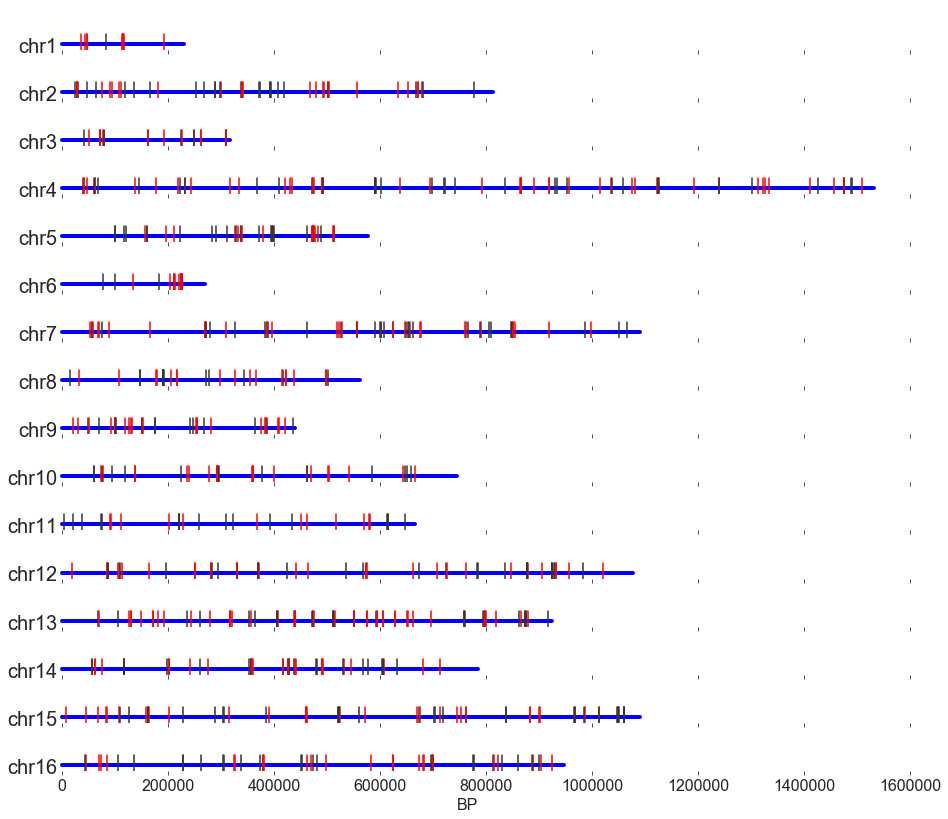

In [63]:
chromo_lens = {
    'chr01': 230218,
    'chr02': 813184,
    'chr03': 316620,
    'chr04': 1531933,
    'chr05': 576874,
    'chr06': 270161,
    'chr07': 1090940,
    'chr08': 562643,
    'chr09': 439888,
    'chr10': 745751,
    'chr11': 666816,
    'chr12': 1078177,
    'chr13': 924431,
    'chr14': 784333,
    'chr15': 1091291,
    'chr16': 948066,
}

# QTL map
fig, subs = pl.subplots(16, 1, figsize=(16, 14), sharex=True, sharey=True)
for chromo_s, hit_loc, gu in bt.loc[pd.notnull(bt['chromosome'])].loc[bt['num.measured']>0].as_matrix(['chromosome', 'insertion_edge', 'Gene.Use']):
    chromo = chromo_s[3:]
    #random_y = np.random.random()*0.7+0.3
    if 'in ' in str(gu):
        subs[int(chromo)-1].plot([hit_loc, hit_loc], [0, 0.4], c='r', zorder=1)
    else:
        subs[int(chromo)-1].plot([hit_loc, hit_loc], [0, 0.4], c='#333333', zorder=1)

for i in range(16):
    subs[i].plot([0, chromo_lens['chr' + str(i+1).zfill(2)]], [0.15, 0.15], lw=4, solid_capstyle='round', c='b', zorder=0)
    subs[i].set_yticks([])
    subs[i].set_ylim([0, 1])
    subs[i].annotate('chr' + str(i+1), xy=(0.04, -0.05), xycoords='axes fraction', fontsize=20, horizontalalignment='right')

subs[15].tick_params(axis='x', which='major', labelsize=16)
subs[15].set_xlabel('BP', fontsize=16)
sns.despine(left=True, bottom=True)    
fig.savefig('../../Figures/supp_figs/insertion_map.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

## QTL map

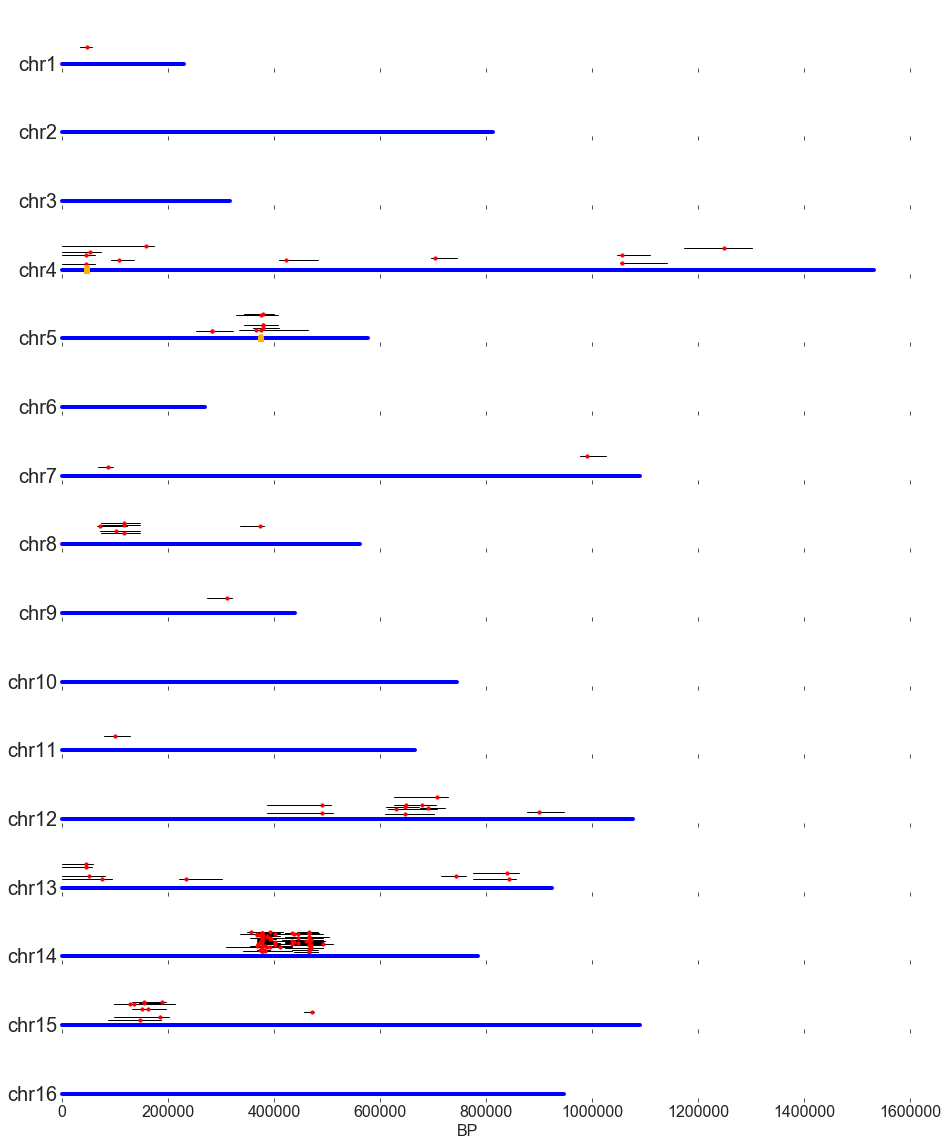

In [64]:
# QTL map
fig, subs = pl.subplots(16, 1, figsize=(16, 20), sharex=True, sharey=True)
for entry in tp['full.model.qtls']:
    if str(entry) != 'nan':
        for qtl in str(entry).split('|'):
            hit, left, right = qtl.split(';')
            chromo = hit[3:5]
            hit_loc = int(hit.split('_')[1])
            if left[3:5] != chromo:
                left_loc = 0
            else:
                left_loc = int(left.split('_')[1])
            if right[3:5] != chromo:
                right_loc = chromo_lens[chromo]
            else:
                right_loc = int(right.split('_')[1])
            random_y = np.random.random()*0.7+0.3
            subs[int(chromo)-1].plot([left_loc, right_loc], [random_y, random_y], c='k', lw=1, zorder=1)
            subs[int(chromo)-1].scatter(hit_loc, random_y, c='r', s=10, zorder=2)
            
subs[3].plot([47000, 47000], [-0.1, 0.2], marker='', c=colors[0], zorder=3, lw=6)
subs[4].plot([376000, 376000], [-0.1, 0.2], marker='', c=colors[0], zorder=3, lw=6)
            
for i in range(16):
    subs[i].plot([0, chromo_lens['chr' + str(i+1).zfill(2)]], [0.15, 0.15], lw=4, solid_capstyle='round', c='b')
    subs[i].set_yticks([])
    subs[i].set_ylim([0, 2])
    subs[i].annotate('chr' + str(i+1), xy=(0.04, -0.05), xycoords='axes fraction', fontsize=20, horizontalalignment='right')

subs[15].tick_params(axis='x', which='major', labelsize=16)
subs[15].set_xlabel('BP', fontsize=16)
sns.despine(left=True, bottom=True)    
fig.savefig('../../Figures/supp_figs/QTL_map.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

LinregressResult(slope=-100.61091672119485, intercept=67.71318192438889, rvalue=-0.26804558492696995, pvalue=0.2821895367231302, stderr=90.40363789466925)
LinregressResult(slope=-46.57182638378211, intercept=36.91964332693563, rvalue=-0.25131372921789596, pvalue=0.3144381645523068, stderr=44.84149704483626)
LinregressResult(slope=-44.38842313379537, intercept=52.4828922817333, rvalue=-0.1961878268738184, pvalue=0.012346185460432394, stderr=17.539396584125377)
LinregressResult(slope=-7.140982914751945, intercept=11.46635205689321, rvalue=-0.14352128157590907, pvalue=0.0684509142736543, stderr=3.8928001897041487)


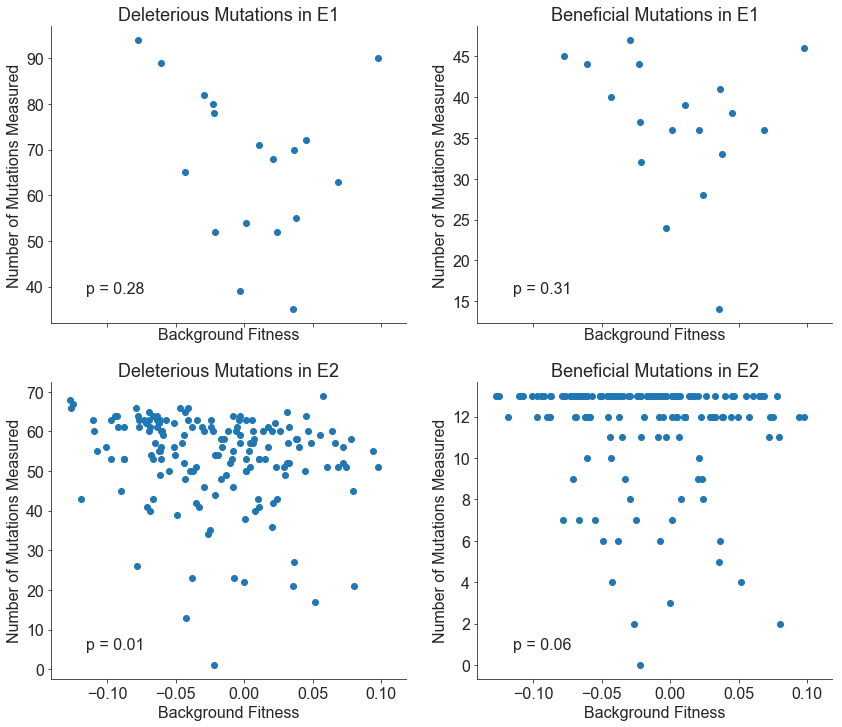

In [65]:
def plot_num_measured(segs, td, sub, mut_type, exp_name):
    nums_measured = [len(td.loc[pd.notnull(td[seg+'.mean.s'])]) for seg in segs]
    x = [seg_to_fit[seg] for seg in segs]
    sub.scatter(x, nums_measured)
    reg = sci_stats.linregress(x, nums_measured)
    print(reg)
    sub.annotate('p = '+str(reg[3])[:4], xy=(0.1, 0.1), xycoords='axes fraction', fontsize=16)
    sub.set_xlabel('Background Fitness', fontsize=16)
    sub.set_ylabel('Number of Mutations Measured', fontsize=16)
    sub.set_title(mut_type + ' Mutations in ' + exp_name, fontsize=18)
    sub.tick_params(axis='both', which='major', labelsize=16)


exps = {'BT': 'E1', 'TP': 'E2'}
es = ['BT', 'TP']
f, subs = pl.subplots(2, 2, figsize=(14, 12), sharex=True)
for i in range(2):
    exp = es[i]
    td = dats[exp]
    plot_num_measured(segs_all[exp], td.loc[td['avg_s']<0].loc[td['num.sig']>=2], subs[i][0], 'Deleterious', exps[exp])
    plot_num_measured(segs_all[exp], td.loc[td['avg_s']>0].loc[td['num.sig']>=2], subs[i][1], 'Beneficial', exps[exp])
sns.despine()
f.savefig('../../Figures/supp_figs/num_mutations_measured_plots.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

# END OF PLOTTING FOR PAPER AND SI

## OK so we would like to see if our DFE stat conclusions still stand if we exclude mutations with QTLs near our markers or the mutation with a detectable lag/saturation effect

Excluding all:
BT mean p 0.05236505863436048
BT variance p 0.35355549940495135
BT skew p 0.6287412411671174
BT kurtosis p 0.31926008568986963
BT significant.beneficial.mutations p 0.02838663522734371
BT significant.deleterious.mutations p 0.8431646795861744
TP mean p 1.413408599879663e-31
TP variance p 4.951639839596735e-13
TP skew p 6.575666036058757e-11
TP kurtosis p 0.28488373876832623
TP significant.beneficial.mutations p 3.47674500740611e-23
TP significant.deleterious.mutations p 4.95263454070307e-07
Excluding mutations with drug marker interactions:
BT mean p 0.05039764865739737
BT variance p 0.35444728299476636
BT skew p 0.6287412499651015
BT kurtosis p 0.3203853803685794
BT significant.beneficial.mutations p 0.02838663522734371
BT significant.deleterious.mutations p 0.8243166599232858
TP mean p 1.449432441053375e-31
TP variance p 4.4718688863135993e-13
TP skew p 5.583244719376382e-11
TP kurtosis p 0.27054703916141276
TP significant.beneficial.mutations p 2.5336868028227292e-23


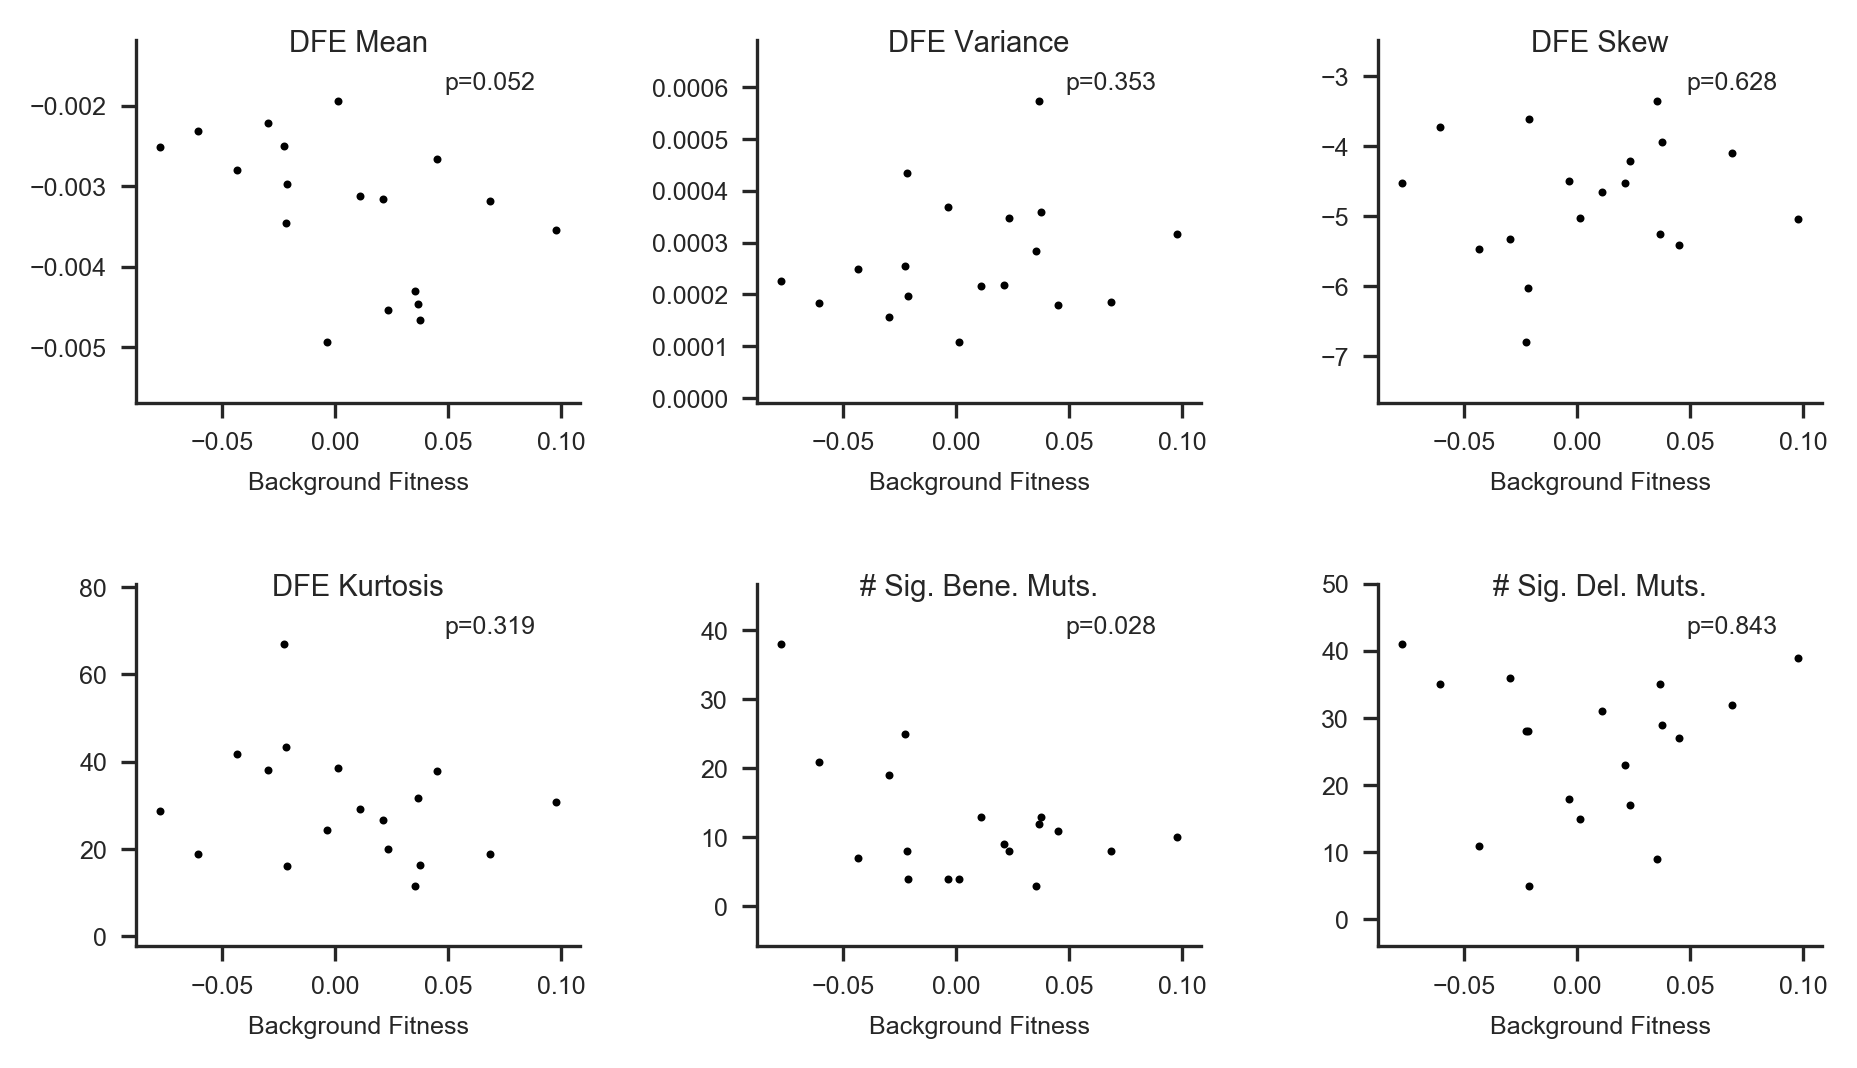

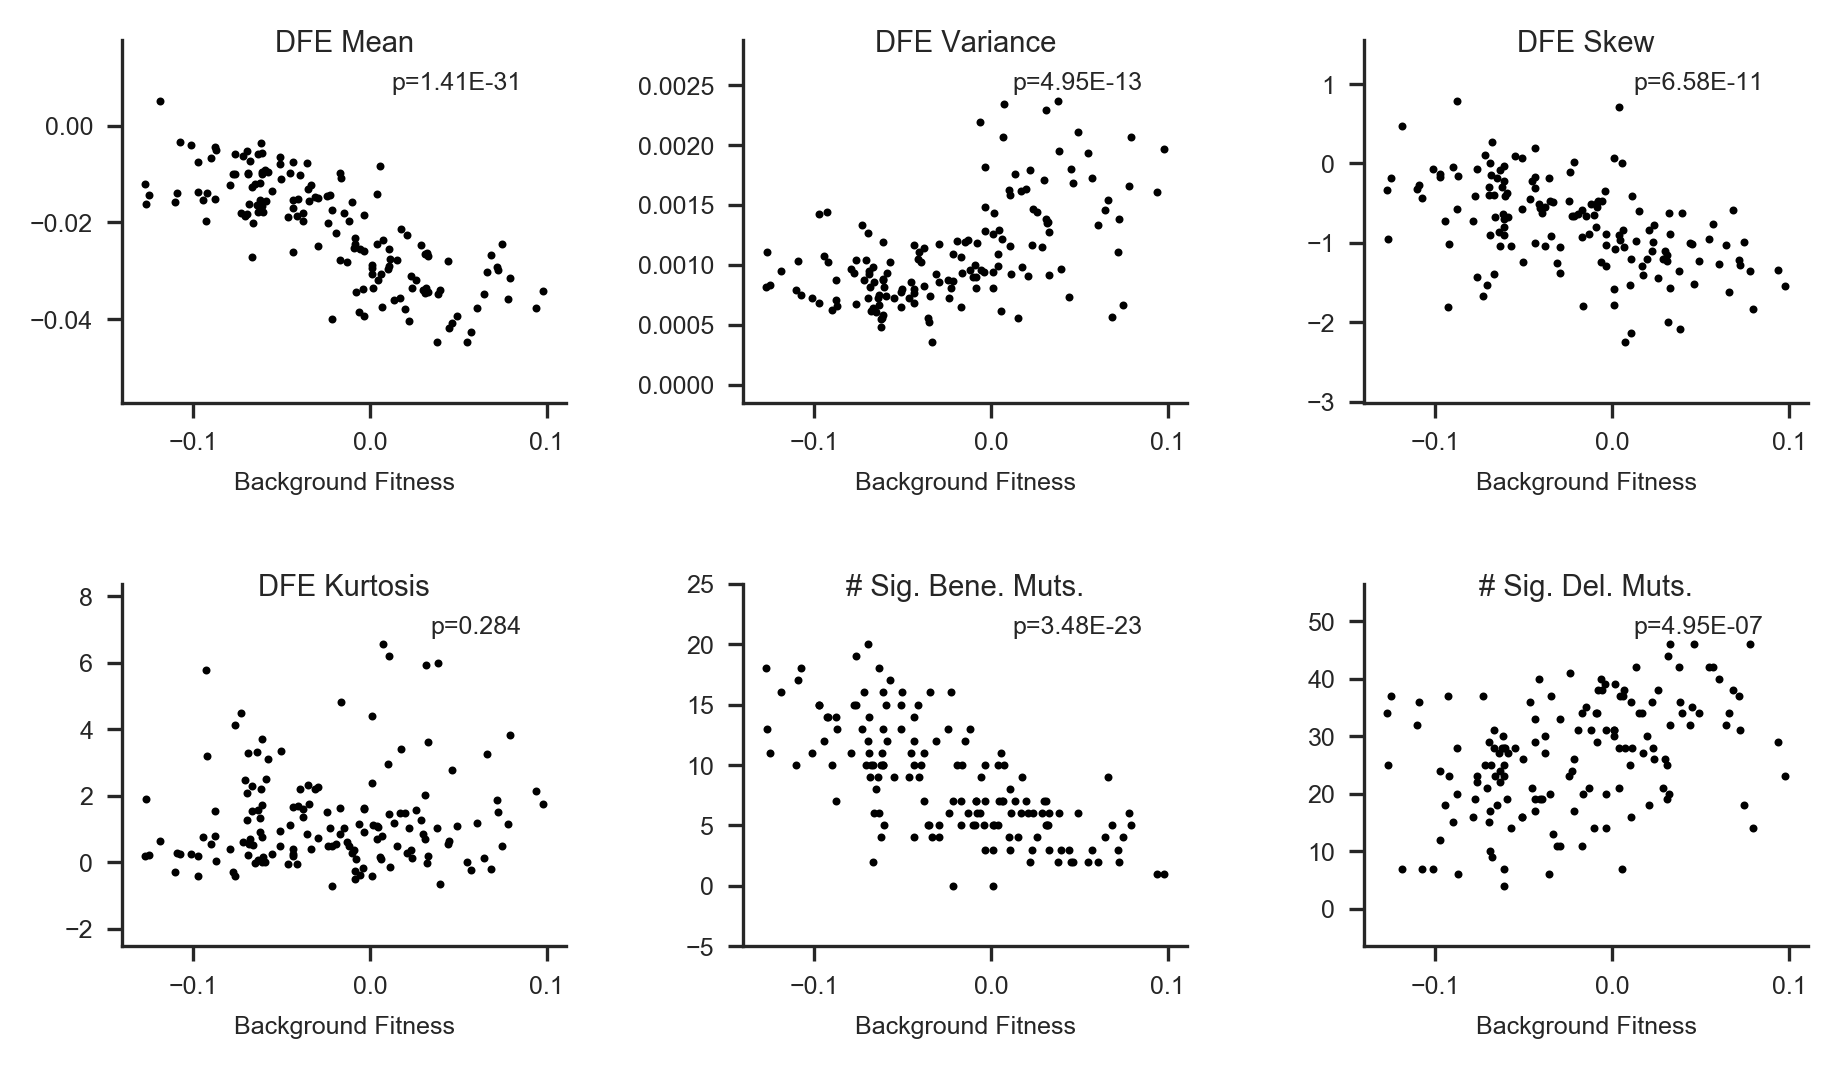

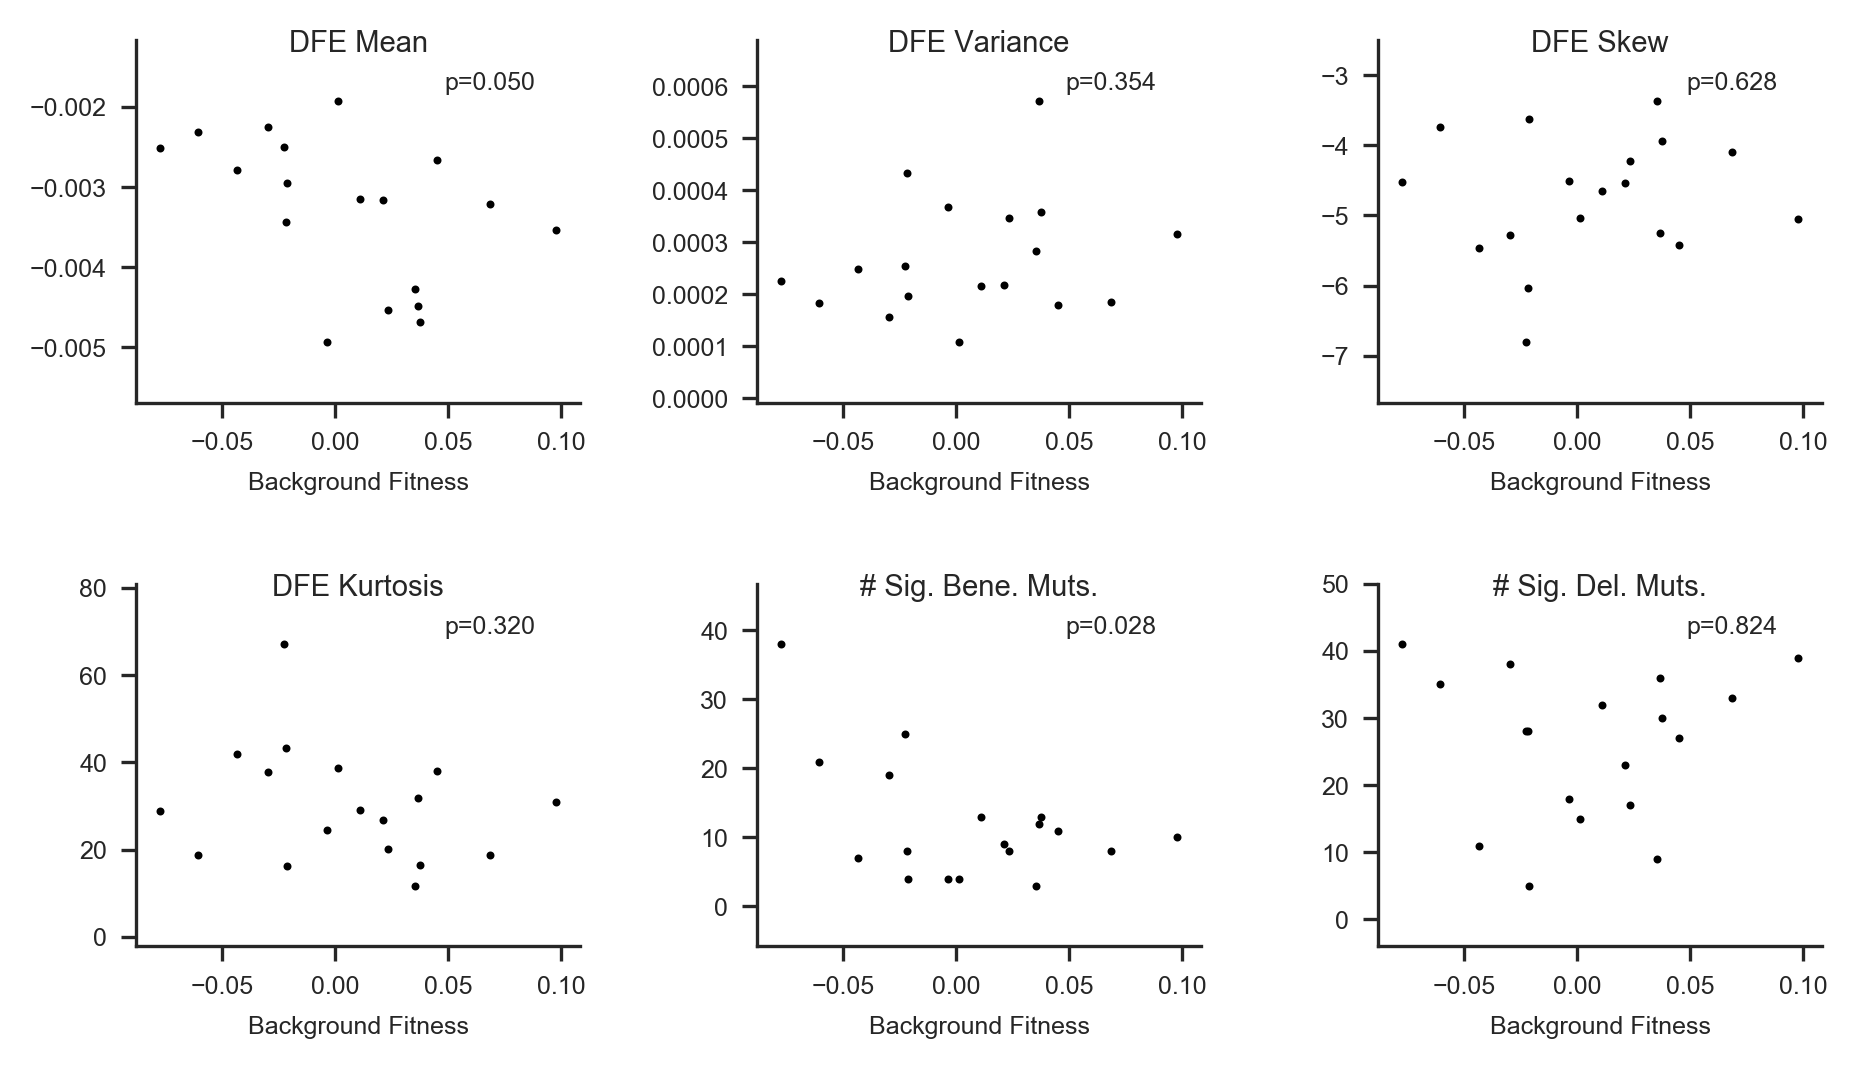

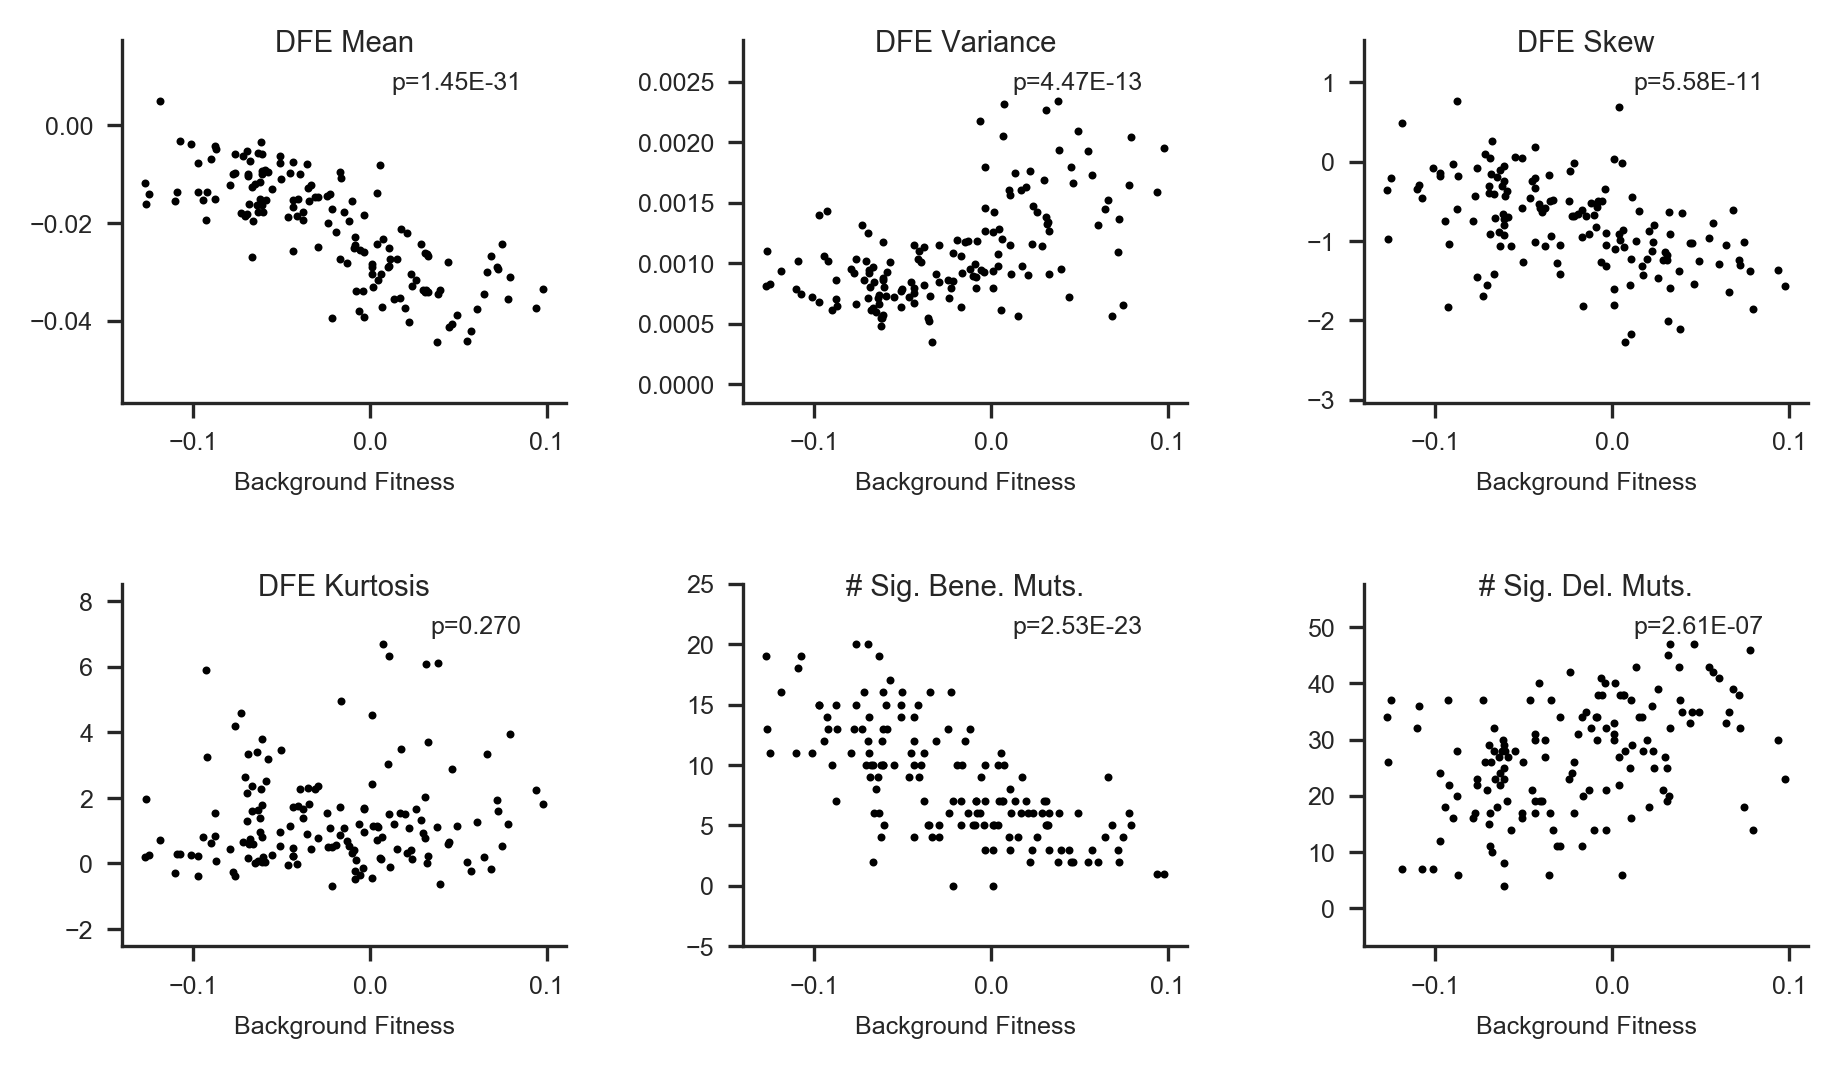

In [66]:
def plot_dfe_statistics(exp, outname):
    all_pads = 1
    dfe_range = [-0.15, 0.07]
    f, subs = pl.subplots(2, 3, figsize=(7.25, 4), dpi=300)
    pl.subplots_adjust(wspace=0.4, hspace=0.5)
    stats = ['mean', 'variance', 'skew', 'kurtosis', 'significant.beneficial.mutations', 'significant.deleterious.mutations']
    stat_names = ['DFE Mean', 'DFE Variance', 'DFE Skew', 'DFE Kurtosis', '# Sig. Bene. Muts.', '# Sig. Del. Muts.']
    s = 0
    for suba in subs:
        for sub in suba:
            plot_dfe_stat(sub, dats[exp+'.DFE'].loc[dats[exp+'.DFE']['DFE.statistic']==stats[s]].iloc[0], segs_use[exp], 
                          [seg_to_fit[seg] for seg in segs_use[exp]], show_pvals=True, qtl_color=True,point_s=1.5)
            sub.set_title(stat_names[s], fontsize=7, y=0.9)
            sub.set_xlabel('Background Fitness', fontsize=6)
            sub.tick_params(axis='both', which='major', labelsize=6)
            s += 1
    sns.despine()
    f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)

def plot_dfe_statistics_w_exclusions(exp, outname, edge_exclude):
    dfe_cols = ['background.fitness', 'mean', 'median', 'variance', 'skew', 'kurtosis', 'significant.beneficial.mutations', 'significant.deleterious.mutations']
    segs = segs_use[exp]
    d = dats[exp]
    seg_stats = dict()
    for seg in segs:
        measured = d.loc[~d['Edge'].isin(edge_exclude)].loc[pd.notnull(d[seg + '.mean.s'])]
        dfe = list(measured[seg + '.mean.s'])
        pvals = list(measured[seg + '.pval'])
        sig = measured.loc[benjamini_hochberg(pvals)[0]] # B/H with alpha=0.05 by default
        sig_dfe = list(sig[seg + '.mean.s'])
        seg_stats[seg] = {
            'background.fitness': seg_to_fit[seg],
            'mean': np.nanmean(dfe),
            'median': np.nanmedian(dfe),
            'variance': np.nanvar(dfe),
            'skew': sci_stats.skew(dfe),
            'kurtosis': sci_stats.kurtosis(dfe),
            'significant.beneficial.mutations': len([i for i in sig_dfe if i > 0]),
            'significant.deleterious.mutations': len([i for i in sig_dfe if i < 0])
        }

    all_pads = 1
    dfe_range = [-0.15, 0.07]
    f, subs = pl.subplots(2, 3, figsize=(7.25, 4), dpi=300)
    pl.subplots_adjust(wspace=0.4, hspace=0.5)
    stats = ['mean', 'variance', 'skew', 'kurtosis', 'significant.beneficial.mutations', 'significant.deleterious.mutations']
    stat_names = ['DFE Mean', 'DFE Variance', 'DFE Skew', 'DFE Kurtosis', '# Sig. Bene. Muts.', '# Sig. Del. Muts.']
    s = 0
    x = [seg_to_fit[seg] for seg in segs]
    for suba in subs:
        for sub in suba:
            y = [seg_stats[seg][stats[s]] for seg in segs]
            pval = sci_stats.linregress(x, y)[3]
            print(exp, stats[s], 'p', pval)
            sub.scatter(x, y, marker='o', linewidth=0.5, c='k', s=2)
            sub.set_title(stat_names[s], fontsize=7, y=0.9)
            sub.set_xlabel('Background Fitness', fontsize=6)
            sub.tick_params(axis='both', which='major', labelsize=6)
            if pval < 0.001:
                sub.annotate('p=' + "{:.2E}".format(pval), xy=(0.9, 0.85), xycoords='axes fraction', fontsize=6, horizontalalignment='right', verticalalignment='bottom')
            else:
                sub.annotate('p=' + str(pval)[:5], xy=(0.9, 0.85), xycoords='axes fraction', fontsize=6, horizontalalignment='right', verticalalignment='bottom')
            y_range = max(y)-min(y)
            sub.set_ylim([min(y)-y_range*0.25, max(y)+y_range*0.25]) # I don't know why pyplot is not doing this well automatically here
            s += 1
    sns.despine()
    if outname:
        f.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
    

qtls_near_cassettes = ['qtl_chr04_40000_70000', # by HO / hphMX 
                       'qtl_chr05_360000_400000'] # by FLO8 / natMX
qtl_df = pd.read_csv('../../Analysis/TP_QTL_results.csv')
near_cas_edges = list(set(qtl_df.loc[qtl_df['QTL_group'].isin(qtls_near_cassettes)]['Edge']))
ex_GC = [tp.loc[tp['Gene.Use']=='in MPC2'].iloc[0]['Edge']]
ex_all = ex_GC + near_cas_edges
    
print('Excluding all:')
plot_dfe_statistics_w_exclusions('BT', None, ex_all)
plot_dfe_statistics_w_exclusions('TP', None, ex_all)
print('Excluding mutations with drug marker interactions:')
plot_dfe_statistics_w_exclusions('BT', None, near_cas_edges)
plot_dfe_statistics_w_exclusions('TP', None, near_cas_edges)

## Some additional scratch plots

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


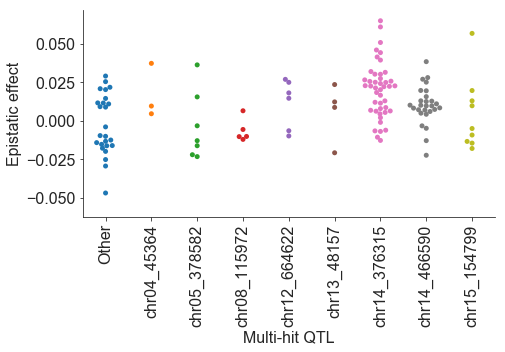

In [67]:
# QTL effect sizes
qtl_df = pd.read_csv('../../Analysis/TP_QTL_results.csv')
mhq_df = pd.read_csv('../../Analysis/Multi_hit_QTLs.csv')
f, sub = pl.subplots(1, 1, figsize=(7, 5))
qtl_group_2_simpler = {i[0]: i[0].split('_')[1] + '_' + str(int(i[1])) for i in mhq_df.as_matrix(['QTL', 'median.loc'])}
qtl_df['QTL_group_simple'] = qtl_df['QTL_group'].apply(lambda q: qtl_group_2_simpler.setdefault(q, 'Other'))
sns.swarmplot(x='QTL_group_simple', y='effect_size', data=qtl_df.sort_values(by='QTL_group_simple'), ax=sub)
pl.xticks(rotation='vertical')
sub.tick_params(axis='both', which='major', labelsize=16)
sns.despine()
sub.set_xlabel('Multi-hit QTL', fontsize=16)
sub.set_ylabel('Epistatic effect', fontsize=16)
pl.tight_layout()
#f.savefig('../../Figures/all/QTL_group_effect_sizes.png', background='transparent')

In [68]:
for exp in exps:
    dats[exp]['avg_s_effect'] = dats[exp].apply(lambda r: np.nanmean([np.abs(r[s+'.mean.s']) for s in segs_all[exp]]), axis=1)
    dats[exp]['top_qtl_es'] = dats[exp]['full_model_qtl_effect_sizes'].apply(lambda es: float(str(es).split(';')[0]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


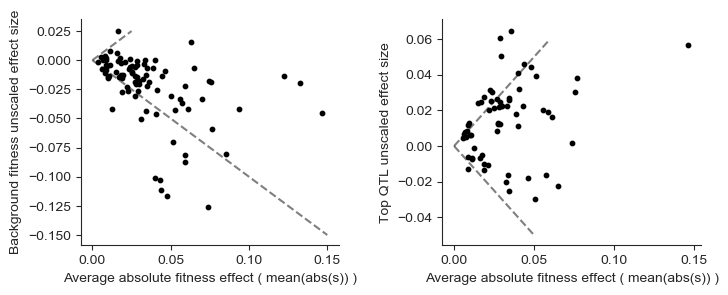

In [69]:
f, subs = pl.subplots(1, 2, figsize=(8, 3), dpi=100)
pl.subplots_adjust(wspace=0.4)
subs[0].plot([0, 0.15], [0, -0.15], linestyle='dashed', alpha=0.5, c='k')
subs[0].plot([0, 0.025], [0, 0.025], linestyle='dashed', alpha=0.5, c='k')
subs[0].scatter(data=dats['TP'], x='avg_s_effect', y='full_model_x_effect_size_measure', s=10, c='k')
subs[0].set_xlabel('Average absolute fitness effect ( mean(abs(s)) )')
subs[0].set_ylabel('Background fitness unscaled effect size')
subs[1].plot([0, 0.05], [0, -0.05], linestyle='dashed', alpha=0.5, c='k')
subs[1].plot([0, 0.06], [0, 0.06], linestyle='dashed', alpha=0.5, c='k')
subs[1].scatter(data=dats['TP'], x='avg_s_effect', y='top_qtl_es', s=10, c='k')
subs[1].set_xlabel('Average absolute fitness effect ( mean(abs(s)) )')
subs[1].set_ylabel('Top QTL unscaled effect size')
sns.despine()

## OK I would like to look at the variance in fitness among my segregants, and then look at the variance in fitness among segregants after a mutation is applied:

In [70]:
def seg_fit_variance_plot(sub, exp):
    xi = [seg_to_fit[seg] for seg in segs_use[exp]]
    vi = np.var(xi)
    variances = []
    for i, r in dats[exp].iterrows():
        measured = [s for s in segs_use[exp] if pd.notnull(r[s + '.mean.s'])]
        if len(measured) > 5:
            xf = [seg_to_fit[s] + r[s + '.mean.s'] for s in measured]
            variances.append(np.var(xf))
    print(exp, len(variances), vi, np.mean(variances))
    sub.hist(variances, facecolor='#333333')
    sub.axvline(x=vi, ymin=0, ymax=1, color='red', linestyle='-', lw=1, label='Variance in\nInitial Fitness')
    sub.set_xlabel('Variance in Final Fitness')
    sub.set_ylabel('# of Mutations')
    sub.legend(loc="upper left", frameon=False)

TP 91 0.0026635729869269485 0.002223748588638673


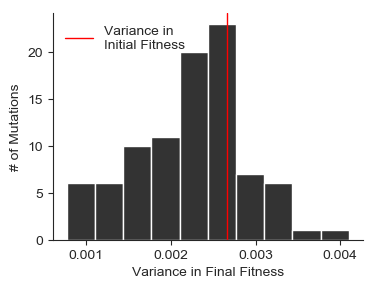

In [71]:
f, sub = pl.subplots(1, 1, figsize=(4, 3), dpi=100)
seg_fit_variance_plot(sub, 'TP')
sns.despine()